# Project goal

Here we have the goals on the covid-19 worldwide analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths and confirmed cases);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a country);</li>
</ul>

# Init process: import libraries, load datasets and evaluate data for next phases

Import ncessary libraries.

In [188]:
import pandas as pd
from pandas import DataFrame
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import copy
import os
import math
from os import listdir
from datetime import date,timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.metrics import max_error
from sklearn.cluster import KMeans

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import decomposition, datasets

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings

from pyramid.arima import auto_arima

%matplotlib inline
%run Utilities.ipynb
warnings.filterwarnings("ignore")



Load dataset about total deaths, new deaths, total cases and new cases.

In [189]:
#load full dataset of coronavirus from internet
df_all_data__ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#rename columns with more meaningful name
df_all_data__.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_all_data__.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths
20020,2020-05-24,Zimbabwe,0,0,56,4
20021,2020-05-25,Zimbabwe,0,0,56,4
20022,2020-05-26,Zimbabwe,0,0,56,4
20023,2020-05-27,Zimbabwe,0,0,56,4
20024,2020-05-28,Zimbabwe,76,0,132,4


FILTRO DATA PER CONGELARLA

In [190]:
df_all_data__=df_all_data__[df_all_data__['Date']<='2020-05-20']
df_all_data__=df_all_data__.reset_index()
df_all_data__.tail()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths
18341,20012,2020-05-16,Zimbabwe,5,0,42,4
18342,20013,2020-05-17,Zimbabwe,2,0,44,4
18343,20014,2020-05-18,Zimbabwe,2,0,46,4
18344,20015,2020-05-19,Zimbabwe,0,0,46,4
18345,20016,2020-05-20,Zimbabwe,0,0,46,4


Load population dataset. The dataset is updated with 2020 data. 
It has been downloaded from:
https://www.kaggle.com/tanuprabhu/population-by-country-2020.

It is currently saved locally.
The dataset contains for each country the number of inhabitants. This dataset is used later to plot covid-19 deaths and cases basing on number of inhabitants.

In [191]:
#load population dataset keeping only the necessary columns 
#(countries and number of inhabitants) renaiming them
df_population = pd.read_csv("../COVID19_analysis/dataset/population_by_country_2020.csv")
df_population = df_population[['Country (or dependency)','Population (2020)']]
df_population.drop_duplicates(inplace = True)
df_population.rename(columns={"Country (or dependency)": "Country",
                            "Population (2020)":"Population"}, inplace = True)
df_population.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


Load lockdown dataset. The dataset has been downloaded from:
https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country#countryLockdowndates.csv.

It is currently saved locally.
It contains the following columns:
<ul>
<li>country</li>
<li>province of the country</li>
<li>date in which the lockdown has been put in place</li>
<li>type of lockdown (full, partial or none)</li>
<li>reference (source of the data).</li>
</ul>

In [192]:
#load lockdown dataset
df_lockdown = pd.read_csv("../COVID19_analysis/dataset/countryLockdowndates.csv")

#rename column relative to country
df_lockdown.rename(columns={"Country/Region": "Country","Date":"Beginning Date"}, inplace = True)
#convert string date format from 'dd/mm/yyyy' to 'yyyy-mm-dd'
df_lockdown['Beginning Date'] = pd.to_datetime(df_lockdown['Beginning Date'])
#rename country value from 'US' to 'United States' where needed
df_lockdown['Country'] = df_lockdown['Country'].apply(lambda x : 'United States' if x == 'US' else x)
#delete 'Reference column'
df_lockdown.drop('Reference', axis = 1, inplace = True)
#if value in 'Province' column is not present, 
#replace it with value in 'Country' column
df_lockdown.Province.fillna(df_lockdown.Country, inplace = True)
#keep only the country where the value in the Country column is equal 
#to the value in the Province column. In this way, it eliminates the
#rows reguarding colonies
df_lockdown = df_lockdown[df_lockdown.Province == df_lockdown.Country]
#drop the Province column because it is not necessary
df_lockdown.drop('Province', axis = 1, inplace = True)
df_lockdown.head()

,Country,Beginning Date,Type
0,Afghanistan,2020-03-24,Full
1,Albania,2020-03-08,Full
2,Algeria,2020-03-24,Full
3,Andorra,2020-03-16,Full
4,Angola,2020-03-24,Full


Load population density dataset. The dataset is downloaded from:
https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv

In [193]:
#load dataset
pd.set_option('mode.chained_assignment', None)
df_population_density_ = pd.read_csv("../COVID19_analysis/dataset/population_density.csv")
df_population_density = df_population_density_[['Country','Pop. Density (per sq. mi.)']]
df_population_density.rename(columns = {'Pop. Density (per sq. mi.)': 'Population density'}, inplace = True)
#trim country value because original dataset has a space at the end
df_population_density['Country'] = df_population_density['Country'].apply(lambda x : x.strip())
df_population_density.head()

,Country,Population density
0,Afghanistan,48.0
1,Albania,124.6
2,Algeria,13.8
3,American Samoa,290.4
4,Andorra,152.1


Merge coronavirus dataset and population dataset.

In [194]:
df_all_data_ =df_all_data__.copy()
df_all_data_ = pd.merge (left = df_all_data_, right = df_population, on = 'Country')
df_all_data_ = pd.merge (left = df_all_data_, right = df_population_density, on = 'Country')
df_all_data_['Date'] = pd.to_datetime(df_all_data_['Date'])
df_all_data_.head()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density
0,0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0
1,1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0
2,2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0
3,3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0
4,4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0


Evaluate number of cases and deaths per million of inhabitants and store the information in new columns of the full dataset.

In [195]:
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New cases',
                                            'New cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total cases',
                                            'Total cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New deaths',
                                            'New deaths per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total deaths',
                                            'Total deaths per million of inhabitants')
df_all_data_.tail()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants
15787,20012,2020-05-16,Zimbabwe,5,0,42,4,14862924,31.3,0.336408,2.825824,0.0,0.269126
15788,20013,2020-05-17,Zimbabwe,2,0,44,4,14862924,31.3,0.134563,2.960387,0.0,0.269126
15789,20014,2020-05-18,Zimbabwe,2,0,46,4,14862924,31.3,0.134563,3.094950,0.0,0.269126
15790,20015,2020-05-19,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126
15791,20016,2020-05-20,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126


Add lockdown information in the full dataset. For each row, create a new column where if in the country for that date was not present the lockdown, the value is set to 0, if the lockdown is partial set a value of 1, if the lockdown is full, set the value to 2. 

In [196]:
#make a copy of the full dataset
#merge lockdown dataset with full dataset
df_all_data = df_all_data_.copy()
df_all_data = df_all_data.merge(df_lockdown, on='Country', how='left')

#create a new column setting an initial default value of -1.
#This value has no meaning. Its only a "jolly" value that evidences
#that the value hano not been set yet
df_all_data['Lockdown state'] = -1

#set a correct value for each row in the full dataset that depends
#on the lockdown type in that particula date for each country
for i in range(len(df_all_data)):
    if(df_all_data.iloc[i]['Type'] == 'None'):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    elif(df_all_data.iloc[i]['Date'] < df_all_data.iloc[i]['Beginning Date']):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    else:
        if(df_all_data.iloc[i]['Type'] == 'Full'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 2
        elif(df_all_data.iloc[i]['Type'] == 'Partial'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 1
        else:
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = -2

#drop Type column because it is not usefull now
del df_all_data['Type']

df_all_data.head()

,index,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state
0,0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
1,1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
2,2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
3,3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
4,4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0


Associate a color to each country that will be used later when plotting the data

In [197]:
colorMap(df_all_data.Country.unique(),0)

# Data visualization

### Analysis by country without considering the number of inhabitants

Firstly, it would be interesting to compare the growth about the number of deaths and cases of some countries starting from a specific point, meant as a common starting point, for a better comparison. Next steps are used to estabilish which is the starting point.

In the first step it is necessary to retrieve what the top ten countries for number of deaths are.

In [198]:
#create a copy of the dataset keeping the necessary columns
df_total_deaths = df_all_data[['Country','Total deaths']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_deaths = df_group_total_deaths.iloc[0:10]
top_10_total_deaths.reset_index(inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths['Total deaths'].sum(), end ="\n\n")
top_10_total_deaths

World number of deaths: 322084



,Country,Total deaths
0,United States,91921
1,United Kingdom,35341
2,Italy,32169
3,France,28022
4,Spain,27888
5,Brazil,17971
6,Belgium,9108
7,Germany,8090
8,Iran,7119
9,Canada,5912


Plot the total number of deaths, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

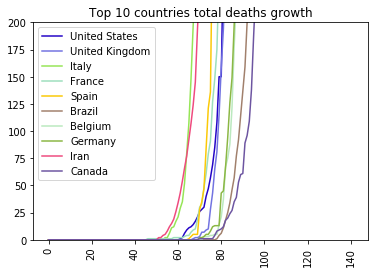

In [199]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth',
                            0, 200)

It is possible to set the starting point to 50 deaths, and this will be the common starting point for comparing the data.

Print data of the top 10 countries for number of deaths and plot the growth starting from the first 50 confirmed deaths.

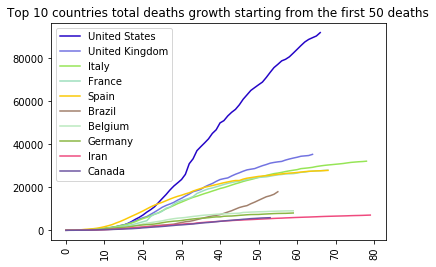

In [200]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            50)

It is intersting to see how the grow in United States is faster than in the other countries. Now, let's plot the data with a logarithmic scale to better view the other countries. The starting point is set to 1.69, that correspond to 50 deaths in the normal scale

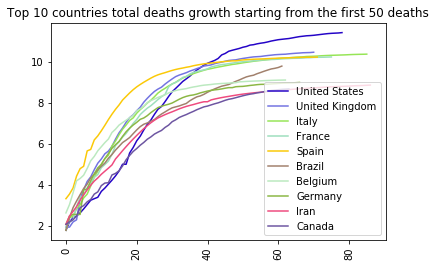

In [201]:
df_total_deaths_log = df_total_deaths.copy()
df_total_deaths_log['Total deaths'] = df_total_deaths_log['Total deaths'].replace(0, 1)
df_total_deaths_log['Total deaths'] = np.log(df_total_deaths_log['Total deaths'])
df_total_deaths_log

#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_log, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            1.69)

This last graph help to understand how the value of total deaths is stabilizing for many countries of the top ten list but in Brazil is still growing at a high rate 

The same procedure is used for confirmed cases.
First, retrieve information about top 10 countries for total number of cases.

In [202]:
#create a copy of the dataset keeping the necessary columns
df_total_cases = df_all_data[['Country','Total cases']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases = df_group_total_cases.iloc[0:10]
top_10_total_cases.reset_index(inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases['Total cases'].sum(), end ="\n\n")
top_10_total_cases

World number of cases: 4828410



,Country,Total cases
0,United States,1528568
1,Russia,299941
2,Brazil,271628
3,United Kingdom,248818
4,Spain,232555
5,Italy,226699
6,Germany,176007
7,Turkey,151615
8,France,143427
9,Iran,124603


Plot the total number of cases, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

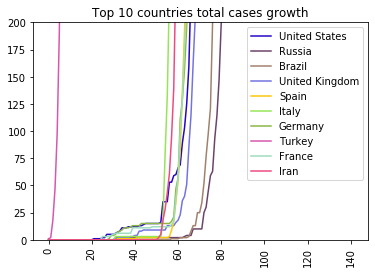

In [203]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'], 'Total cases',
                            'Top 10 countries total cases growth',
                            0, 200)

Because of a stabilization period in many countries around about 25 cases, this time, the starting point is set to 25 cases.

Print data of the top 10 countries for number of cases and plot the growth starting from the first 25 confirmed case.

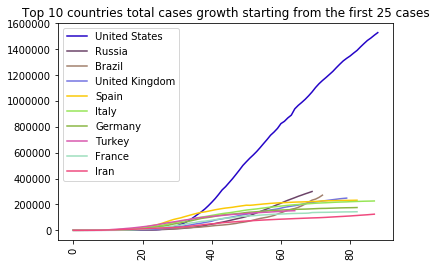

In [204]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first 25 cases',
                            25)

### Analysis by country considering the number of inhabitants

As done before, firstly, print data of top ten countries for total deaths.

In [205]:
#create a copy of the dataset
df_total_deaths_x_million = df_all_data[['Country',
                                         'Total deaths per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total deaths per million of inhabitants',ascending = False, inplace = True)


#loc the first 10 rows
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[0:10]
top_10_total_deaths_x_million.reset_index(inplace = True)
top_10_total_deaths_x_million

,Country,Total deaths per million of inhabitants
0,San Marino,1208.334561
1,Belgium,785.875434
2,Andorra,660.066007
3,Spain,596.473798
4,Italy,532.054722
5,United Kingdom,520.593263
6,France,429.301252
7,Sweden,370.621030
8,Netherlands,333.530358
9,Ireland,316.133587


Plot data day by day of the top 10 countries to try to detect a common starting point for comparing the growth focusing on a range between 0 and 20 cases per million of inhabitants.

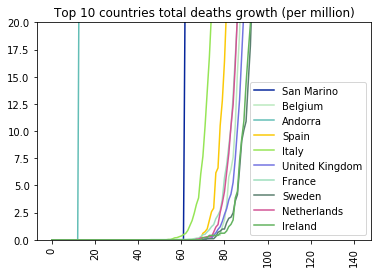

In [206]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth (per million)',
                            0, 20)

For some countries, such as Andorra and San Marino, there is not a slow growth but they have a very fast increase. A part these, it is possible to consider, as a common starting point, a value of 2.5.

Plot the growth starting from the point where the rate was upper than 2.5.

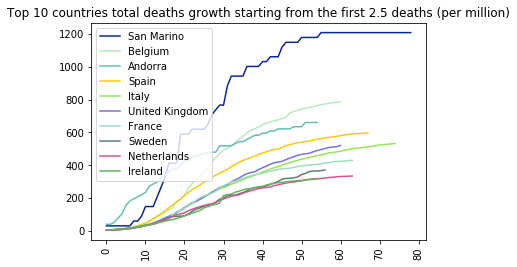

In [207]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth starting from the first 2.5 deaths (per million)',
                            2.5)

The growth is almost linear for the top 10 countries.

Print data of the top 10 countries for number of cases per million.

In [208]:
#create a copy of the dataset
df_total_cases_x_million = df_all_data[['Country',
                                         'Total cases per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total cases per million of inhabitants',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[0:10]
top_10_total_cases_x_million.reset_index(inplace = True)
top_10_total_cases_x_million

,Country,Total cases per million of inhabitants
0,San Marino,19303.881406
1,Qatar,12358.675804
2,Andorra,9849.220216
3,Luxembourg,6322.905917
4,Iceland,5280.694403
5,Spain,4973.930151
6,Singapore,4921.763548
7,Ireland,4911.310454
8,Belgium,4813.875309
9,United States,4617.993226


As done before, plot the growth to detect a common comparison starting point focusing on a range between 0 and 20 cases per million of inhabitants.

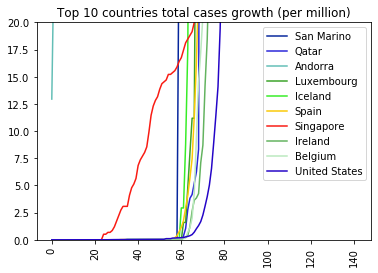

In [209]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth (per million)',
                            0, 20)

The growth increases very fast. A common starting point for comparison could be 2.5 cases per million of inhabitants.

Plot the growth starting from the point where the rate was upper than 2.5 cases per million of inhabitants.

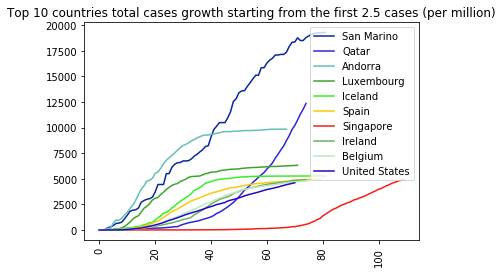

In [210]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth starting from the first 2.5 cases (per million)',
                            2.5)

It is interesting to see how small countries have a higher concentration of deaths and cases and they occupies the first places in number of cases and deaths in this ranking. It is now possible to find out if at a first glance there is a correlation between population density and the virus spread. Following, the population density distribution. 

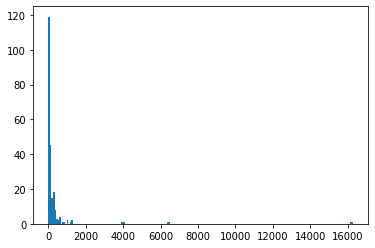

In [211]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.show()

To better visualize the distribution, a cut is placed at 1500 in the plot visualization. There are a few values upper than that. 

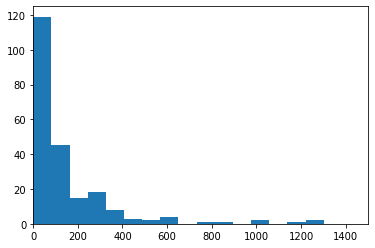

In [212]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.xlim(0, 1500)
plt.show()

Print also some statistical information of these data.

In [213]:
df_population_density['Population density'].describe()

count      227.000000
mean       379.047137
std       1660.185825
min          0.000000
25%         29.150000
50%         78.800000
75%        190.150000
max      16271.500000
Name: Population density, dtype: float64

It is now necessary to print the population density of the top 10 countries for total number of deaths and for total number of deaths per million of inhabitants. Then we can use the mean value of the population density to compare the two groups.

In [214]:
print('Population density of top 10 countries for number of deaths:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths:

            Country  Population density
36           Canada                 3.3
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
190           Spain                80.0
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6
19          Belgium               340.0

Mean value: 130.09


In [215]:
print('Population density of top 10 countries for number of deaths per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths per million of inhabitants:

            Country  Population density
195          Sweden                20.0
98          Ireland                57.8
190           Spain                80.0
69           France               111.3
4           Andorra               152.1
101           Italy               193.0
213  United Kingdom               247.6
19          Belgium               340.0
146     Netherlands               397.1
177      San Marino               479.5

Mean value: 207.84


The same computation is done for the total number of cases.

In [216]:
print('Population density of top 10 countries for number of cases:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases:

            Country  Population density
169          Russia                 8.4
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
190           Spain                80.0
206          Turkey                90.2
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6

Mean value: 105.62


In [217]:
print('Population density of top 10 countries for number of cases per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases per million of inhabitants:

           Country  Population density
93         Iceland                 2.9
214  United States                31.0
98         Ireland                57.8
166          Qatar                77.4
190          Spain                80.0
4          Andorra               152.1
121     Luxembourg               183.5
19         Belgium               340.0
177     San Marino               479.5
184      Singapore              6482.2

Mean value: 788.64


In this last computation there is Singapore that can be considered as an "outlier" for the computation of the mean value. It is possible to recompute the mean value without considering it.

In [218]:
top_10_without_singapore = top_10_total_cases_x_million[top_10_total_cases_x_million['Country'] != 'Singapore']
print('\nNew mean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_without_singapore['Country'].to_list())]['Population density'].mean())


New mean value: 156.0222222222222


Because in the top 10 countries of the two lists, a part a couple of coutries, the max value is around 500 and basing on the density population distribution most of the values are under 500, in the next step the density population dataset is filtered to remove all the data over 500. Next, statistical description is computed to better explain the impact of population density on virus spread.

In [219]:
df_filtered_population_density = df_population_density.loc[df_population_density['Population density'] < 500]
print("Statistical description of population density under a value of 500")
df_filtered_population_density.describe()

Statistical description of population density under a value of 500


,Population density
count,209.000000
mean,106.803828
std,108.814715
min,0.000000
25%,26.700000
50%,66.900000
75%,142.700000
max,496.000000


Comparing mean values of the two lists, for the number of deaths, there is a slighty difference between the top 10 countries for number of deaths and the top 10 countries for number of deaths per million of inhabitants in respect of the population density. So, the initial hypotesis that the population density could have an impact in the virus spread, is not verified.
About the difference in the confirmed cases, although the difference is more evident, it is not significant if it is taken in consideration that the standard deviation  of the population density in the filtered data is 108. The difference between the two means value is about 150 that is a similar value compared to the standard deviation. At a first glance, it is safe to say that there is not a strong correlation between the virus spread and the population density. 

## Focus on the number of new deaths an new cases.

Print data of the top ten day/country for new deaths

In [220]:
#copy the dataframe
df_new_deaths = df_all_data[['Date','Country','New deaths']].copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
15229,2020-04-16,United States,4928
15231,2020-04-18,United States,3770
15237,2020-04-24,United States,3179
15243,2020-04-30,United States,2611
15235,2020-04-22,United States,2524
15228,2020-04-15,United States,2408
15250,2020-05-07,United States,2353
15230,2020-04-17,United States,2299
15251,2020-05-08,United States,2239
15239,2020-04-26,United States,2172


Evaluate the moving average for new deaths taking in consideration a period of 10 days.

In [221]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new deaths for the row date
df_matrix_new_deaths = get_matrix_dataset(df_, 'New deaths')
df_matrix_new_deaths.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-16,32,0,7,0,0,0,3,3,0,0,...,384,1662,0,0,0,0,0,2,0,0
2020-05-17,0,0,6,2,0,0,7,3,0,0,...,468,1186,0,0,0,0,0,4,0,0
2020-05-18,1,0,6,0,0,0,3,5,0,0,...,170,808,1,1,0,0,0,1,0,0
2020-05-19,4,0,7,0,0,0,16,1,0,1,...,160,791,0,1,0,0,0,0,0,0
2020-05-20,5,0,6,0,0,0,11,3,0,0,...,545,1568,0,0,0,0,0,8,0,0


In [222]:
#evaluate the moving average of the new cases matrix
df_new_deaths_moving_average_ = df_matrix_new_deaths.copy()
df_new_deaths_moving_average_ = evaluate_moving_average(df_new_deaths_moving_average_, 10)
df_new_deaths_moving_average_.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-16,4,0,5,0,0,0,9,1,0,1,...,594,1791,0,0,0,0,0,0,0,0
2020-05-17,4,0,5,0,0,0,7,1,0,1,...,579,1788,0,0,0,0,0,0,0,0
2020-05-18,4,0,5,0,0,0,8,1,0,1,...,602,1855,0,0,0,0,0,0,0,0
2020-05-19,4,0,5,0,0,0,8,1,0,1,...,622,1942,0,0,0,0,0,0,0,0
2020-05-20,4,0,5,0,0,0,8,1,0,0,...,593,1882,0,0,0,0,0,0,0,0


It is now interesting to see the evaluation, basing on the moving average of the new deaths, about the number of days between the day in which the lockdow has been set and when the peak in number of deaths has been reached. This evaluation is displayed for the top 10 countries for number of deaths. The number of days between the lockdown date and the peak is showed inside each graph.

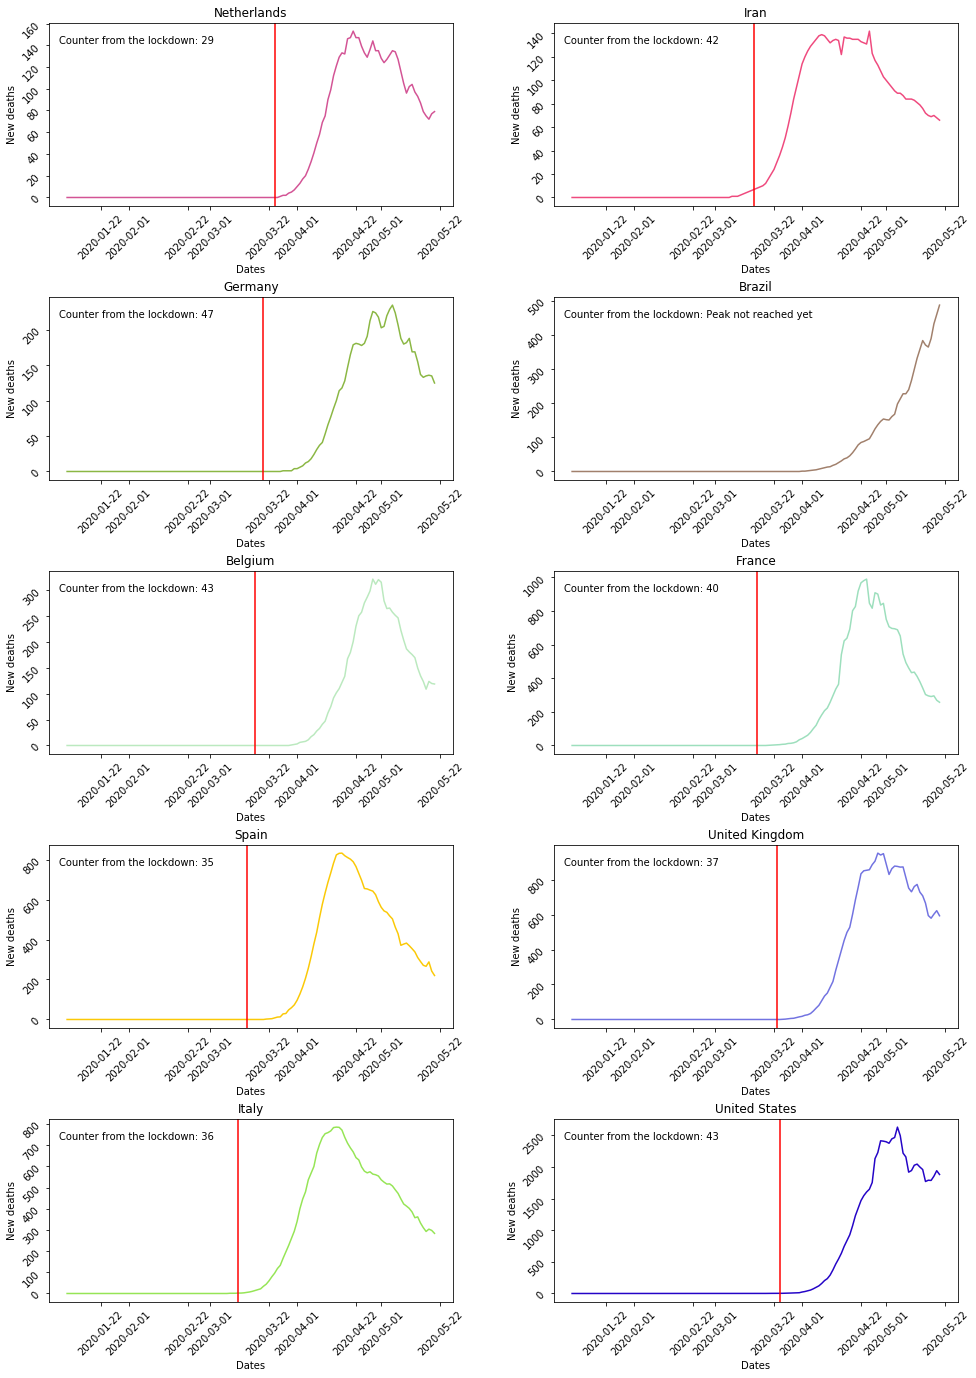

In [223]:
#calculating the top ten for deaths making the sum of all the deaths and plotting it
max_deaths=df_new_deaths_moving_average_.sum(axis = 0, skipna = True)
top_ten_new_deaths_moving_average=max_deaths.sort_values()[-10:].index

plotWithLockdown(top_ten_new_deaths_moving_average,df_lockdown,df_new_deaths_moving_average_,'New deaths')


Print data of the top ten day/country for new cases

In [224]:
#copy the dataframe
df_new_cases = df_all_data[['Date','Country','New cases']].copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
15239,2020-04-26,United States,48529
15235,2020-04-22,United States,37289
15224,2020-04-11,United States,35527
15218,2020-04-05,United States,34272
15245,2020-05-02,United States,33955
15223,2020-04-10,United States,33901
15222,2020-04-09,United States,33323
15232,2020-04-19,United States,32922
15217,2020-04-04,United States,32425
15230,2020-04-17,United States,31667


Evaluate the moving average for new cases taking in consideration a period of 10 days.

In [225]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new cases for the row date
df_matrix_new_cases = get_matrix_dataset(df_, 'New cases')
df_matrix_new_cases.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-16,1063,18,187,0,0,0,345,184,0,30,...,3560,25508,8,46,4,1,0,19,14,5
2020-05-17,0,17,192,0,0,0,326,239,0,17,...,3450,24487,1,50,45,5,0,18,11,2
2020-05-18,262,13,198,0,0,0,0,189,0,9,...,3534,18873,1,12,37,2,0,4,74,2
2020-05-19,408,2,182,0,0,0,566,351,0,15,...,2711,21841,3,49,77,4,0,2,8,0
2020-05-20,581,1,176,0,2,0,438,218,0,8,...,2412,19970,1,78,131,0,0,37,11,0


In [226]:
#evaluate the moving average of the new cases matrix
df_new_cases_moving_average_ = df_matrix_new_cases.copy()
df_new_cases_moving_average = evaluate_moving_average(df_new_cases_moving_average_, 20)
df_new_cases_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-16,54,17,93,13,0,0,98,45,1,50,...,5078,28914,8,78,8,1,0,0,2,1
2020-05-17,58,17,96,11,0,0,110,46,1,47,...,5028,30070,9,76,8,1,0,0,2,1
2020-05-18,59,17,97,10,0,0,106,48,1,43,...,5061,29885,9,74,8,0,0,0,2,1
2020-05-19,66,17,102,9,0,0,113,50,1,38,...,5095,29482,10,70,8,0,0,0,2,1
2020-05-20,70,17,103,8,0,0,115,52,1,34,...,5020,29022,9,69,8,0,0,0,2,1


The same evaluation done before for the number of deaths, is now done for the new cases.

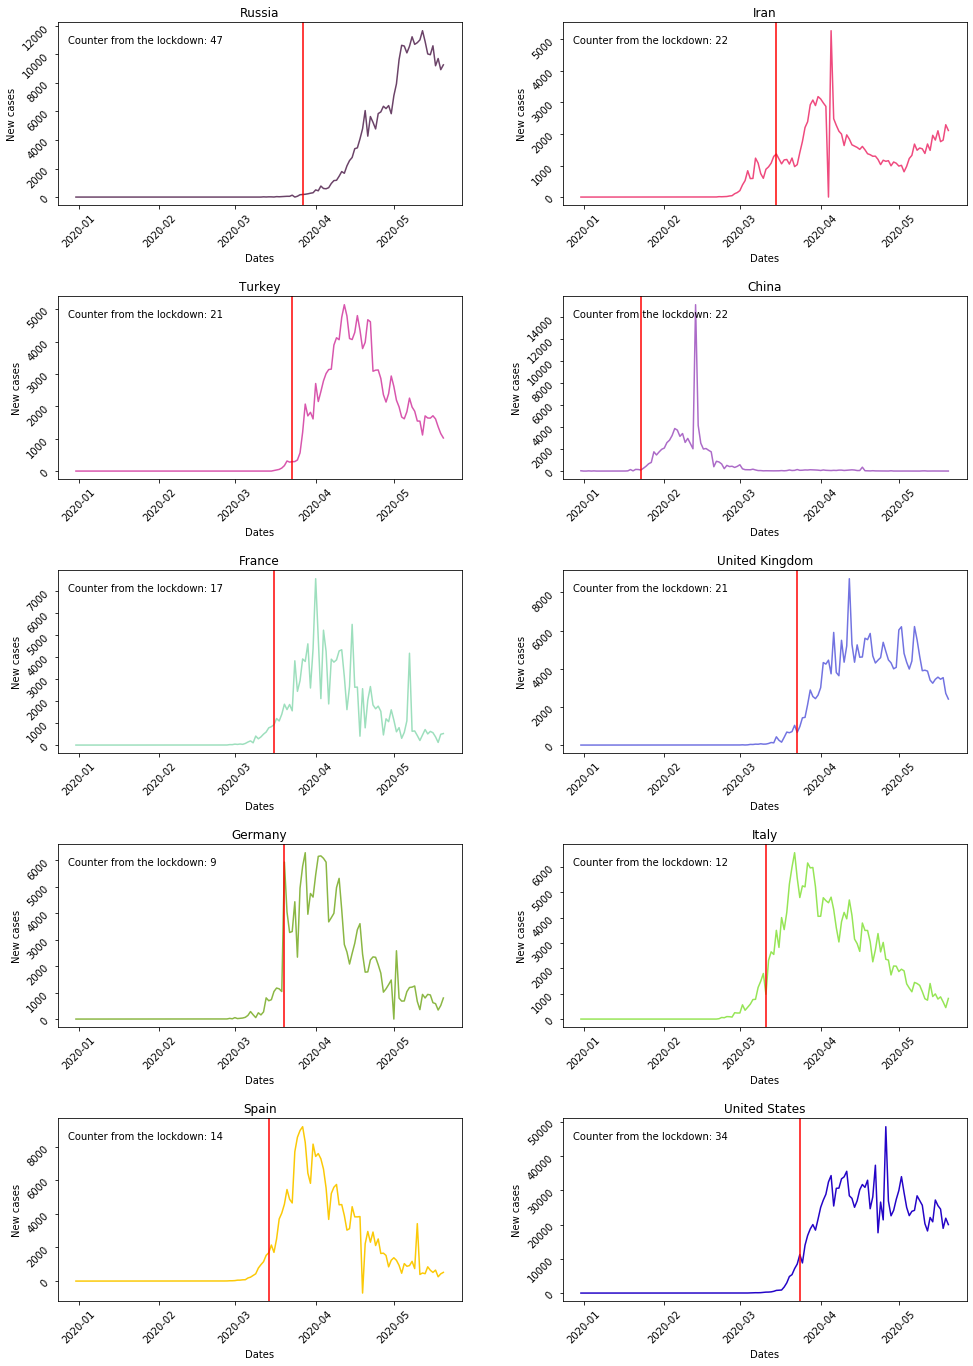

In [227]:
max_cases=df_new_cases_moving_average.sum(axis = 0, skipna = True)
top_ten_new_cases_moving_average=max_cases.sort_values()[-10:].index

plotWithLockdown(top_ten_new_cases_moving_average,df_lockdown,df_new_cases_moving_average_,'New cases')

An immediate consideration that can be done looking at these final data is both for the new cases graphs of the top 10 countries and for the number of deaths the peak is always passed, the average period of the new cases to get the peak is faster than the corresponding value of the number of deaths. A hypotesis could be that once the virus is identified in a country, there are a lot of cases already present in that country. The lockdown is a containtment action that allow to block the spread so, in a few days, the number of new cases decrease. Unlike this, the deaths come later because the virus doesn't kill a person immediately. It needs many days to make it happen. The only countries where the peak is not passed is Brazil, where since now no lockdown measures has been put in place.

Another consideration that can be highlighted is that the graph about deaths is more linear than the number of cases. This could be because the number of cases is also influenced by the number of swabs executed in each day. Unfortunately this data are not available for al the countries and often are not reliable.

## Analysis of the percentage of growth

In this section, an evaluation on the growth rate for the total number of deaths and cases has been computed. The growth rate is evaluated considering the difference in terms of total number of deaths or total number of cases between two consecutive days divided the total number of deaths or cases that the desease has generated for a particular country. Then the top 5 countries data are displayed.

Create a dataframe with the total deaths grow rate for each country day by day.

In [41]:
df_total_deaths = df_all_data[['Date','Country','Total deaths']].copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 1, 'Total deaths')

Plot the death grow rate of the top 5 countries for deaths.

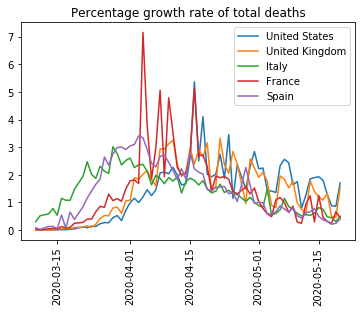

In [42]:
#get the list of the top 5 countries
top_5_death_countries_list = top_10_total_deaths['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_deaths_growth = death_growth_rate[top_5_death_countries_list]

some_countries_deaths_growth=some_countries_deaths_growth[some_countries_deaths_growth>0]
some_countries_deaths_growth=some_countries_deaths_growth.dropna()
for country in top_5_death_countries_list:
    plt.plot(some_countries_deaths_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total deaths")
plt.show()

Create a dataframe with the total cases grow rate for each country day by day.

In [43]:
df_total_cases = df_all_data[['Date','Country','Total cases']].copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 1, 'Total cases')

Plot the grow rate of the top 5 countries for number of cases.

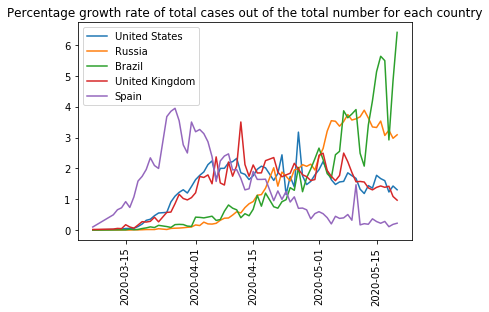

In [44]:
#get the list of the top 5 countries
top_5_case_countries_list = top_10_total_cases['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_cases_growth = case_growth_rate[top_5_case_countries_list]
some_countries_cases_growth=some_countries_cases_growth[some_countries_cases_growth > 0]
some_countries_cases_growth=some_countries_cases_growth.dropna()
for country in top_5_case_countries_list:
    plt.plot(some_countries_cases_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total cases out of the total number for each country")
plt.show()

In this last graphs it is possible to see which are the days, for the top 5 countries, more critical. Obviously, the real problem is in the days after each peak, where the emergency must be managed in term of cases (hospital) or deaths (death bodies management). In the number of new cases, Brazil and Russia have a similar growth but while in Russia the peak seems to be reached, in Brazil the trend is growing yet (22-05-2020).

## Try to compute some first predictions

Now, we will try to forecast the cases series of Italy and Sweden. Since now, Sweden is the only conuntry that has not yet introduced lockdown counter measure in Europe. We want to try to predict how the new cases number will be in the next days and compare it with Italy.  

Firstly, let's plot our series

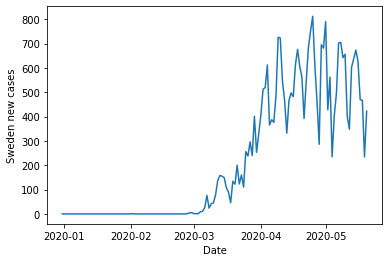

In [228]:
country_series='Sweden'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

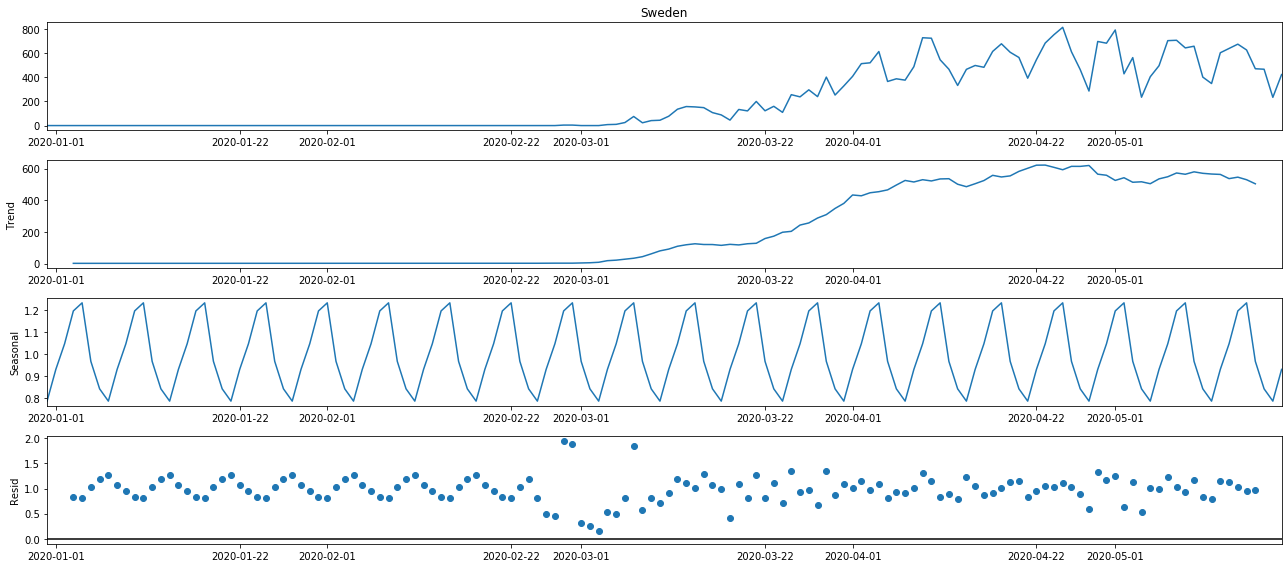

In [229]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

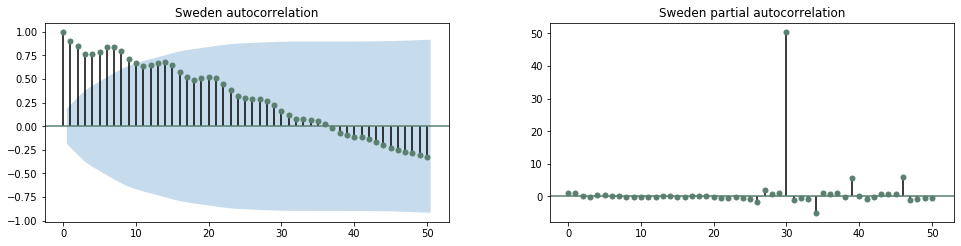

In [230]:
autocorrelationPlot('Sweden',df_matrix_new_cases,50)

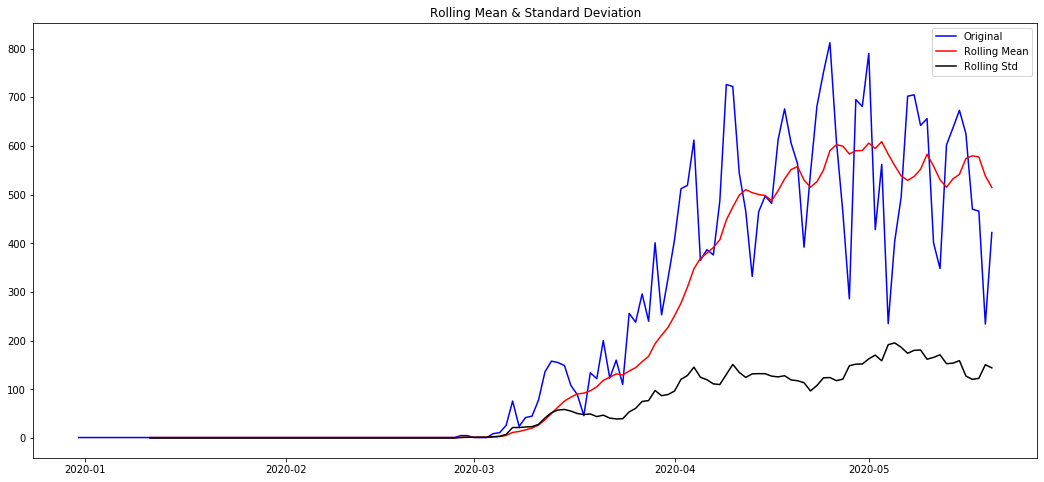

Results of Dickey-Fuller Test:


Test Statistic                  -0.560198
p-value                          0.879725
#Lags Used                      13.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

In [231]:
dftest, dfoutput = test_stationarity(df_series)
dfoutput

In [232]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1578.523, BIC=1592.822, Fit time=0.960 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1656.803, BIC=1662.523, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1634.380, BIC=1645.819, Fit time=0.349 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1586.625, BIC=1598.064, Fit time=0.590 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1576.887, BIC=1594.045, Fit time=1.164 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=1628.100, BIC=1642.399, Fit time=0.759 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1580.860, BIC=1600.879, Fit time=3.887 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1650.128, BIC=1661.567, Fit time=0.224 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1560.669, BIC=1583.548, Fit time=3.611 seconds
Fit ARIMA: order=(0, 1, 1) s

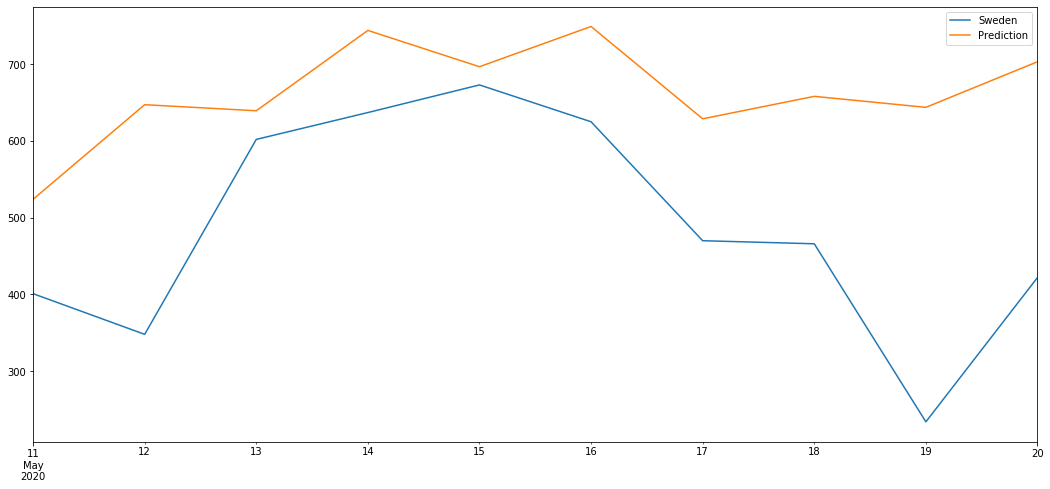

In [240]:
train = df_series.loc['2020-03-01':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

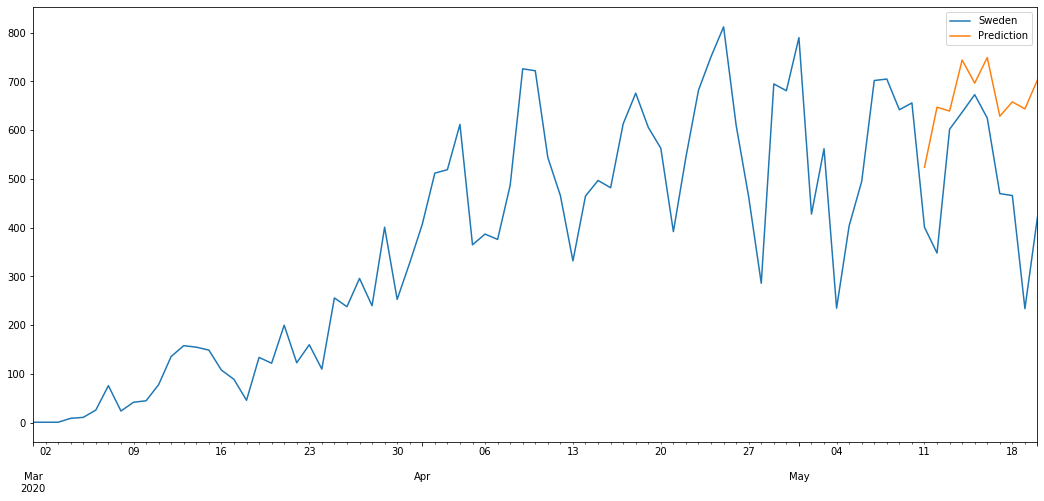

In [241]:
pd.concat([df_series.loc['2020-03-01':'2020-05-25'],future_forecast],axis=1).plot()

Now, let's focus on Italy

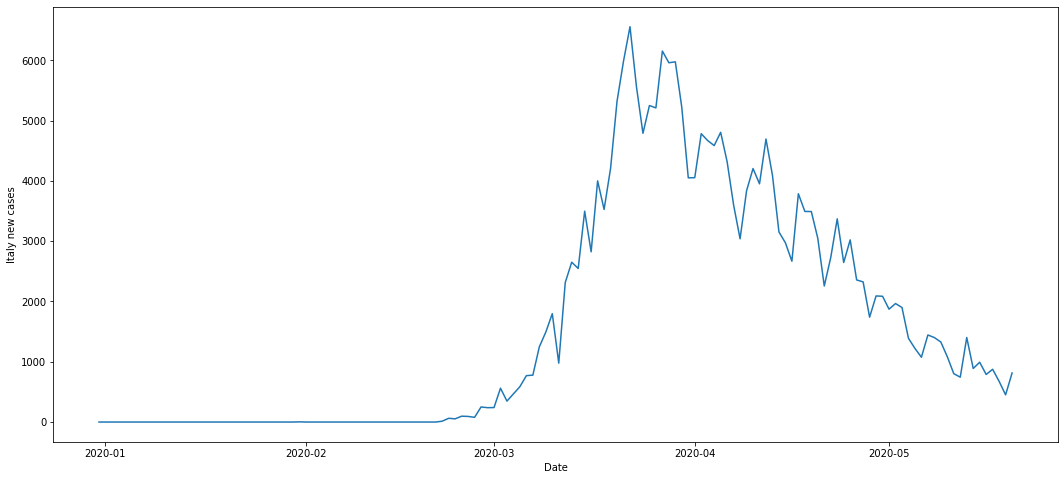

In [243]:
country_series='Italy'
df_series = df_matrix_new_cases[country_series].copy()

plt.xlabel('Date')
plt.ylabel(country_series+' new cases')
plt.plot(df_series)

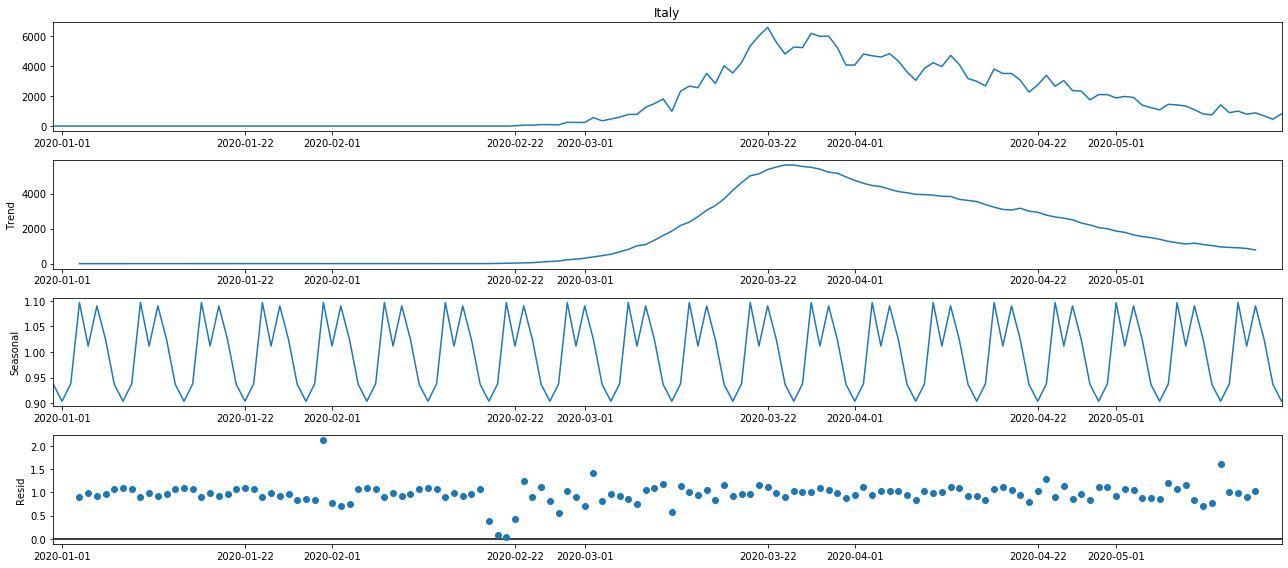

In [244]:
#Decompose the serie
rcParams['figure.figsize'] = 18, 8
df_series = df_series.replace(0, 1)
decomposition = sm.tsa.seasonal_decompose(df_series, model='multiplicative')
fig = decomposition.plot()
plt.show()

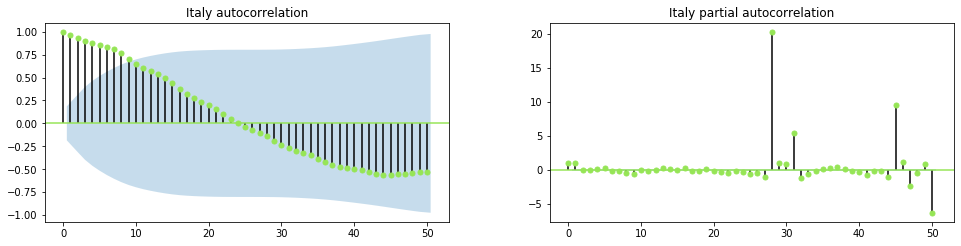

In [245]:
autocorrelationPlot('Italy',df_matrix_new_cases,50)

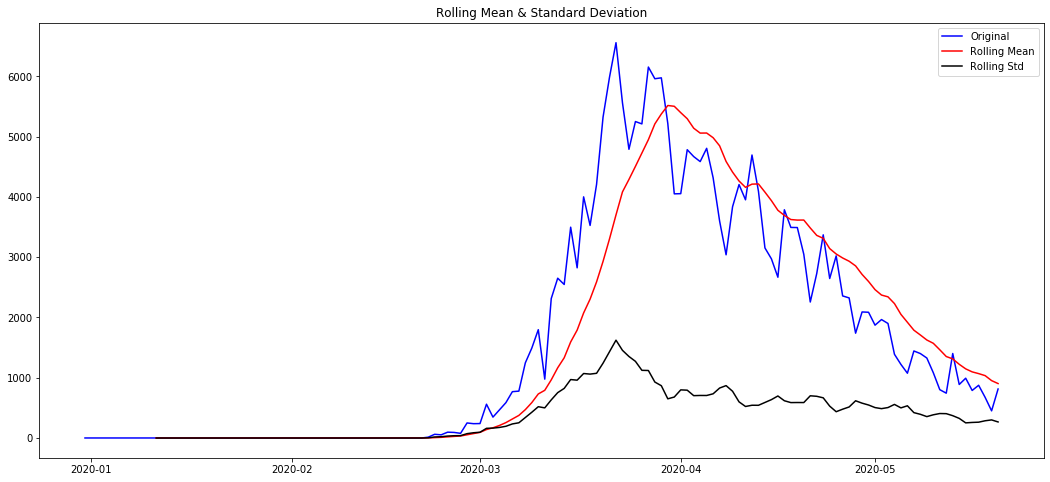

Results of Dickey-Fuller Test:


Test Statistic                  -1.782243
p-value                          0.389313
#Lags Used                      12.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [246]:
dftest, dfoutput = test_stationarity(df_series)
dfoutput

In [247]:
stepwise_model = auto_arima(df_series, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1958.027, BIC=1972.326, Fit time=0.537 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2023.267, BIC=2028.987, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2000.794, BIC=2012.233, Fit time=0.362 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1955.343, BIC=1966.782, Fit time=0.447 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1957.177, BIC=1971.476, Fit time=0.896 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=2024.164, BIC=2032.743, Fit time=0.034 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1957.082, BIC=1971.381, Fit time=2.373 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1959.384, BIC=1976.543, Fit time=2.749 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=1954.026, BIC=1962.605, Fit time=0.299 seconds
Fit ARIMA: order=(0, 1, 0) s

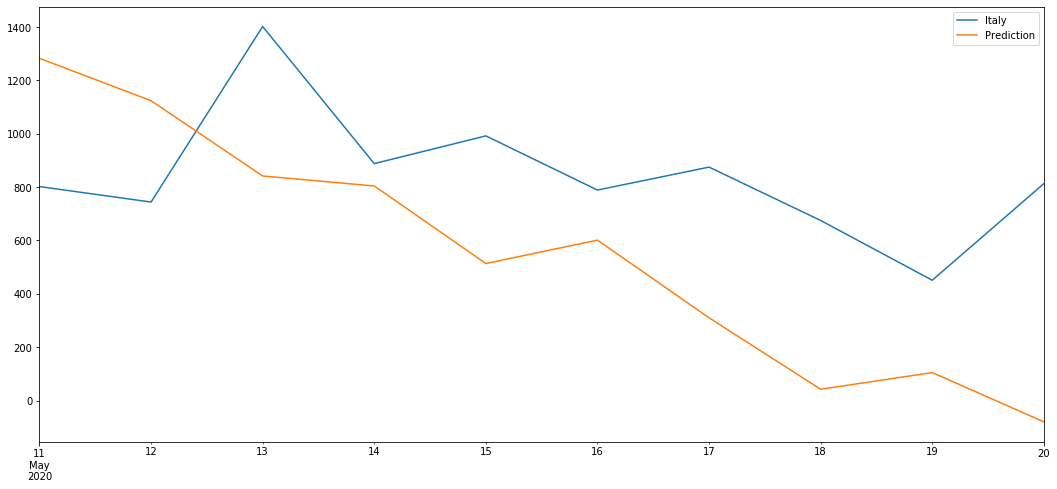

In [294]:
train = df_series.loc['2020-02-22':'2020-05-10']
test = df_series.loc['2020-05-11':]
test_size = len(test)
stepwise_model.fit(train)
future_forecast = stepwise_model.predict(n_periods=test_size)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=["Prediction"])
pd.concat([test,future_forecast],axis=1).plot()

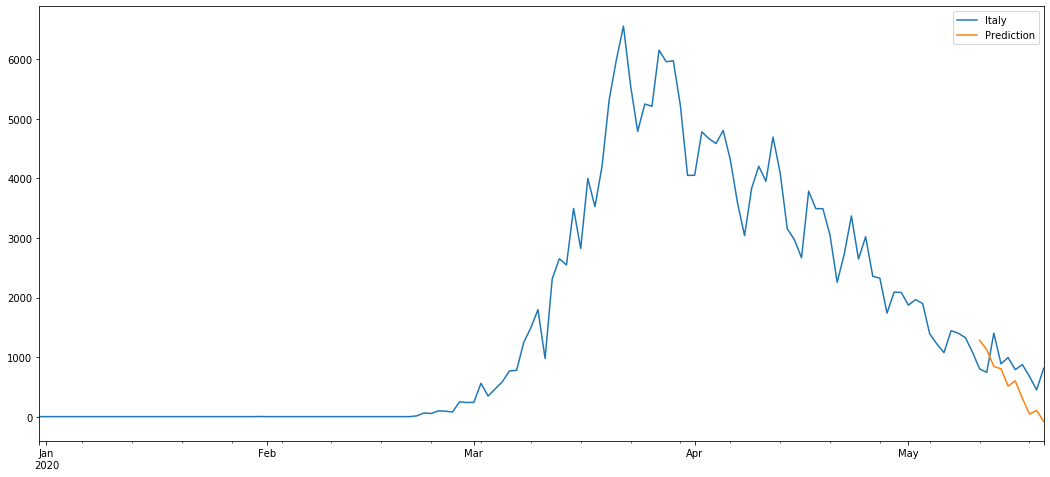

In [295]:
pd.concat([df_series,future_forecast],axis=1).plot()

.........

# Models

## Correlation between population density and total cases

Now, let's try to see if there is a correlation between the population density in the world countries and the total cases.
Firstly, prepare the dataset with the necessary columns. We have to add a column to store the data of each country about the ratio between the total number of cases and the population.

In [250]:
yesterday = '2020-05-20'

df_regression_friendly=df_all_data[pd.to_datetime(df_all_data['Date'])==pd.to_datetime(yesterday) ].copy()
df_regression_friendly=df_regression_friendly[df_regression_friendly['Lockdown state']==2]
df_regression_friendly['Ratio cases-population']=df_regression_friendly['Total cases']/df_regression_friendly['Population']
del df_regression_friendly['New cases']
del df_regression_friendly['New deaths']
del df_regression_friendly['New cases per million of inhabitants']
del df_regression_friendly['New deaths per million of inhabitants']
df_regression_friendly=df_regression_friendly.reset_index()
del df_regression_friendly['level_0']
del df_regression_friendly['index']
df_regression_friendly.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197
1,2020-05-20,Albania,949,31,2877797,124.6,329.766137,10.772129,2020-03-08,2,0.000330
2,2020-05-20,Algeria,7377,561,43851044,13.8,168.228606,12.793310,2020-03-24,2,0.000168
3,2020-05-20,Andorra,761,51,77265,152.1,9849.220216,660.066007,2020-03-16,2,0.009849
4,2020-05-20,Angola,50,2,32866272,9.7,1.521316,0.060853,2020-03-24,2,0.000002


In [251]:
df_regression_friendly.corr()

,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Lockdown state,Ratio cases-population
Total cases,1.000000,0.927471,0.212382,-0.035083,0.177205,0.232594,NaN,0.177205
Total deaths,0.927471,1.000000,0.159277,-0.031307,0.204009,0.397629,NaN,0.204009
Population,0.212382,0.159277,1.000000,-0.024254,-0.093923,-0.054543,NaN,-0.093923
Population density,-0.035083,-0.031307,-0.024254,1.000000,0.057818,0.042576,NaN,0.057818
Total cases per million of inhabitants,0.177205,0.204009,-0.093923,0.057818,1.000000,0.763091,NaN,1.000000
Total deaths per million of inhabitants,0.232594,0.397629,-0.054543,0.042576,0.763091,1.000000,NaN,0.763091
Lockdown state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratio cases-population,0.177205,0.204009,-0.093923,0.057818,1.000000,0.763091,NaN,1.000000


Let's try to compute a linear regression between the population density and the total cases, to see if there is a linear correlation between these two variables.

Coefficients: 
 [-3.87872269]
Mean squared error: 3114675147.69
Coefficient of determination: -0.21


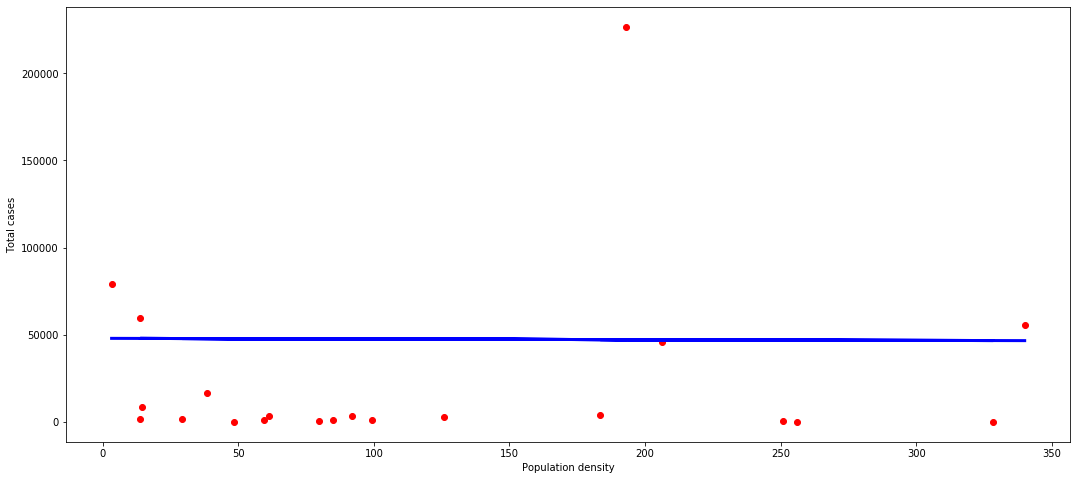

In [252]:
linearRegression(df_regression_friendly['Population density'], df_regression_friendly['Total cases'],'Population density','Total cases')

The statistic descriptions and the graph suggest that there isn't a linea correlation and also, that there isn't any type of correlation.

Now, let's try to compute the same analysis but scaling the total number of cases with the population of each country. In this way, it is possible to see the correlation between the population density and the total number of cases in ratio with the population, that is a more correct way to compare the data.

Coefficients: 
 [9981799.87428977]
Mean squared error: 2518844364.34
Coefficient of determination: 0.16


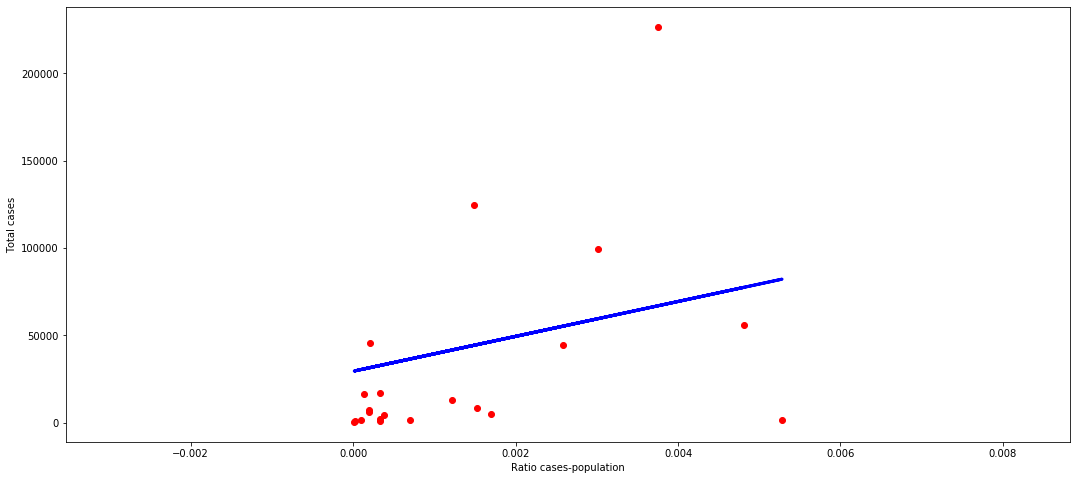

In [253]:
linearRegression(df_regression_friendly['Ratio cases-population'], df_regression_friendly['Total cases'],'Ratio cases-population','Total cases')

At a first glance, no correlation seems to be exist. But before draw this conclusion, let's try to remove the data that seems to be an outlier and then try to compute the regression again. Basing on the last graph, we consider outlier the value greater than 40000 total cases, because, respect to the other countries, their value is very far and could be particular cases of the virus spread.

Coefficients: 
 [-2.11219151]
Mean squared error: 52747172.16
Coefficient of determination: -0.02


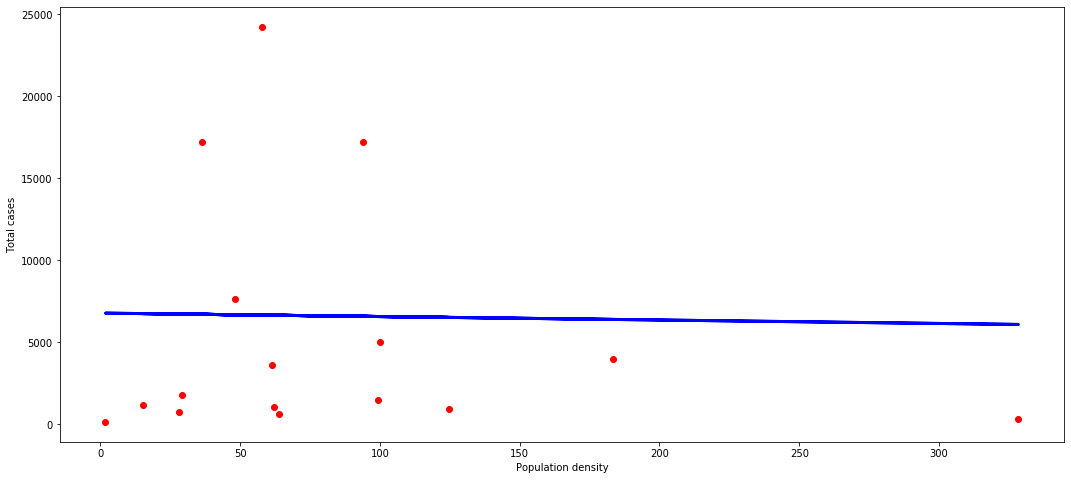

Coefficients: 
 [519668.01202835]
Mean squared error: 74635825.34
Coefficient of determination: 0.16


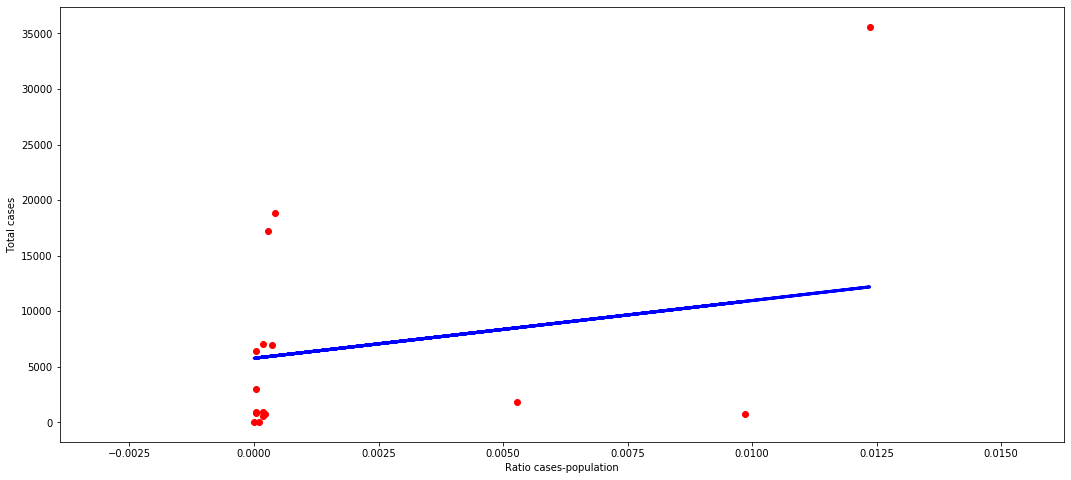

In [254]:
df_regression_friendly_WO=df_regression_friendly[df_regression_friendly['Total cases']<40000]
df_regression_friendly_WO=df_regression_friendly_WO[df_regression_friendly_WO['Population density']<800]

linearRegression(df_regression_friendly_WO['Population density'], df_regression_friendly_WO['Total cases'],'Population density','Total cases')
linearRegression(df_regression_friendly_WO['Ratio cases-population'], df_regression_friendly_WO['Total cases'],'Ratio cases-population','Total cases')


Even without the outliers, no correlation appears to be present between these the population density and the total number of cases.
So, we can conclude that the population density has not a direct impact in term of covid-19 cases. This evaluation was already been done during the visualization phase, where we had note that there were in the top ten countries for total number of cases, countries with a high rate of population density and countries with a low rate of population density.

FILTRIAMO PER I PAESI DOPO I 200 CASI PER VEDERE SE CAMBIA QUALCOSA

In [255]:
country_list=[]
beg_list=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                country_list.append(country)
                beg_list.append((country,df_matrix_new_cases.index[i]))
                break

                
df_regression_friendly=df_regression_friendly[df_regression_friendly['Country'].isin(country_list)]   
df_regression_friendly.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197
5,2020-05-20,Argentina,8796,393,45195774,14.4,194.619966,8.695503,2020-03-20,2,0.000195
6,2020-05-20,Armenia,5041,64,2963243,99.9,1701.176718,21.597959,2020-03-24,2,0.001701
7,2020-05-20,Austria,16257,632,9006398,97.7,1805.050143,70.172337,2020-03-16,2,0.001805
8,2020-05-20,Azerbaijan,3518,41,10139177,91.9,346.970962,4.043721,2020-03-02,2,0.000347


CALCOLO PERCENTUALE

In [256]:
growth_percentage=[]
country_list=[]
for i in range(len(beg_list)):
    c=df_all_data[df_all_data['Country']==beg_list[i][0]]
    d=c[c['Date']==(beg_list[i][1]+ timedelta(days=7))]
    e=c[c['Date']==beg_list[i][1]]

    try:
        
        growth_percentage.append(((d['Total cases'].iloc[0]-e['Total cases'].iloc[0])/d['Total cases'].iloc[0])*100)
        country_list.append(beg_list[i][0])
    except:
        print()


  
df_regression_friendly=df_regression_friendly[df_regression_friendly['Country'].isin(country_list)] 

g2=[]
c2=[]


for i in range(len(growth_percentage)):
            if(country_list[i] in df_regression_friendly['Country'].tolist()):
                g2.append(growth_percentage[i])
                c2.append(country_list[i])
                


In [257]:
df_regression_friendly['Growth rate']=g2
df_regression_friendly

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population,Growth rate
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197,39.068201
5,2020-05-20,Argentina,8796,393,45195774,14.4,194.619966,8.695503,2020-03-20,2,0.000195,19.301628
7,2020-05-20,Austria,16257,632,9006398,97.7,1805.050143,70.172337,2020-03-16,2,0.001805,76.315065
9,2020-05-20,Bahrain,7532,12,1701575,1050.5,4426.487225,7.052290,2020-02-25,2,0.004426,28.631358
10,2020-05-20,Bangladesh,25121,370,164689383,1023.4,152.535637,2.246654,2020-03-19,2,0.000153,70.076878
12,2020-05-20,Belgium,55791,9108,11589623,340.0,4813.875309,785.875434,2020-03-17,2,0.004814,69.900749
15,2020-05-20,Bolivia,4481,189,11673021,8.2,383.876633,16.191181,2020-03-12,2,0.000384,39.679934
19,2020-05-20,Canada,79101,5912,37742154,3.3,2095.826327,156.641828,2020-03-16,2,0.002096,75.826216
20,2020-05-20,Chile,49579,509,19116201,21.3,2593.559254,26.626629,2020-03-26,2,0.002594,62.322666
21,2020-05-20,China,84065,4638,1439323776,136.9,58.405900,3.222347,2020-01-23,2,0.000058,90.920321


In [258]:
df_regression_friendly.corr()

,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Lockdown state,Ratio cases-population,Growth rate
Total cases,1.000000,0.922675,0.165073,-0.088818,0.243280,0.297330,NaN,0.243280,0.394957
Total deaths,0.922675,1.000000,0.108236,-0.047479,0.290723,0.548971,NaN,0.290723,0.450320
Population,0.165073,0.108236,1.000000,0.102457,-0.212005,-0.124091,NaN,-0.212005,0.253978
Population density,-0.088818,-0.047479,0.102457,1.000000,0.064241,0.068684,NaN,0.064241,0.023134
Total cases per million of inhabitants,0.243280,0.290723,-0.212005,0.064241,1.000000,0.459919,NaN,1.000000,0.235212
Total deaths per million of inhabitants,0.297330,0.548971,-0.124091,0.068684,0.459919,1.000000,NaN,0.459919,0.488882
Lockdown state,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ratio cases-population,0.243280,0.290723,-0.212005,0.064241,1.000000,0.459919,NaN,1.000000,0.235212
Growth rate,0.394957,0.450320,0.253978,0.023134,0.235212,0.488882,NaN,0.235212,1.000000


## World new cases prediction modelling

Now,...............

In [259]:
array=[]
justNumbers=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                 array.append((country,len(df_matrix_new_cases[country][i:])))
                 justNumbers.append(len(df_matrix_new_cases[country][i:]))
                 break
print(array)
print("\nNumber of countries with more than 200 cases in a day:",len(array))

[('Afghanistan', 20), ('Argentina', 25), ('Armenia', 4), ('Australia', 60), ('Austria', 66), ('Azerbaijan', 1), ('Bahrain', 37), ('Bangladesh', 36), ('Belarus', 42), ('Belgium', 63), ('Bolivia', 18), ('Brazil', 61), ('Cameroon', 47), ('Canada', 60), ('Chile', 56), ('China', 118), ('Colombia', 43), ('Denmark', 70), ('Dominican Republic', 50), ('Ecuador', 61), ('Egypt', 46), ('Finland', 46), ('France', 73), ('Germany', 75), ('Ghana', 31), ('Honduras', 13), ('Hungary', 41), ('India', 49), ('Indonesia', 44), ('Iran', 81), ('Ireland', 58), ('Israel', 62), ('Italy', 83), ('Japan', 49), ('Kazakhstan', 37), ('Kuwait', 26), ('Luxembourg', 57), ('Malaysia', 58), ('Mexico', 46), ('Moldova', 36), ('Morocco', 46), ('Netherlands', 65), ('Nigeria', 20), ('Norway', 70), ('Oman', 37), ('Pakistan', 53), ('Panama', 42), ('Peru', 49), ('Philippines', 53), ('Poland', 53), ('Portugal', 61), ('Qatar', 70), ('Romania', 54), ('Russia', 53), ('Saudi Arabia', 57), ('Serbia', 53), ('Singapore', 41), ('South Afric

DATA LA NATURA CURVILINEA DEL MODELLO, PROVIAMO A VEDERE SE UNA REGRESSIONE POLINOMIALE RIESCE IN QUALCHE MODO A PREDIRRE DOVE ANDRà UNA CERTA CURVA

In [260]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                 if (couple[1]>=50):
                     filtered_new_cases[couple[0]]=np.array(df_matrix_new_cases[couple[0]][i:i+50])
                     break

filtered_new_cases.head()

,China,Italy,Iran,Germany,Spain,France,United States,Denmark,Norway,Qatar,...,Sweden,Chile,South Africa,Romania,Pakistan,Philippines,Poland,Russia,Serbia,Dominican Republic
0,259,250,205,284,233,410,271,252,212,238,...,256,220,218,263,211,272,249,228,202,208
1,441,238,385,163,330,286,287,160,132,0,...,238,164,243,160,118,343,224,270,82,175
2,665,240,523,55,433,372,351,128,0,58,...,296,304,17,308,99,666,193,302,0,96
3,787,561,835,237,772,497,511,23,286,17,...,240,299,93,192,414,0,256,501,159,108
4,1753,347,586,157,975,595,777,48,170,64,...,401,230,46,293,252,227,243,440,160,90


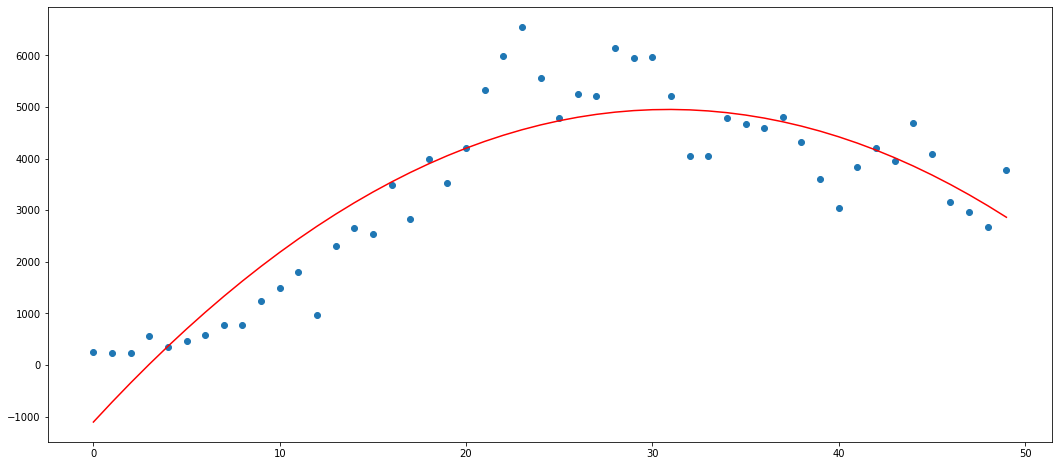

In [261]:
poly_features=PolynomialFeatures(degree=2,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()

linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

Now try with degree equal to 4.

Italy


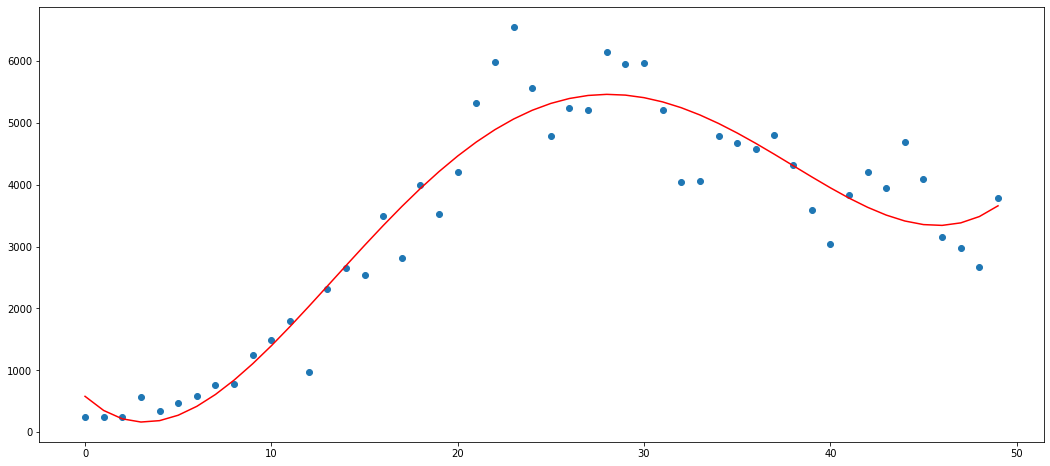

In [262]:
poly_features = PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()
linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

Italy


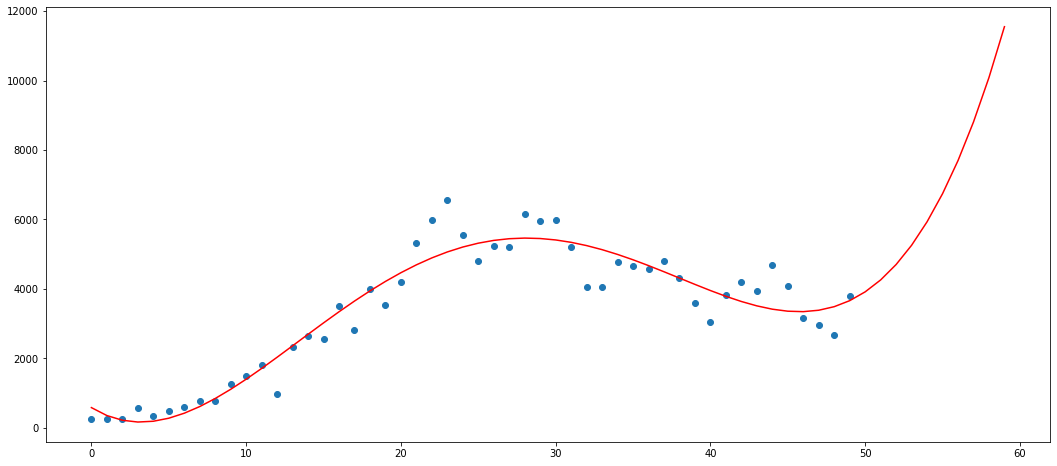

In [263]:

x_poly=poly_features.fit_transform(np.array(range(0,60)).reshape(-1, 1))



predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

FA SCHIFO, PROVIAMO CON QUELLA LINEARE NORMALE

REGRESSIONE LINEARE SULLA CURVA DI DISCESA


In [264]:


for i in range(0,len(df_matrix_new_cases['Italy'])):
        if(df_matrix_new_cases['Italy'][i]>200):
                 
                     italy_cases=np.array(df_matrix_new_cases['Italy'][i:])
                     italy_dates=np.array(df_matrix_new_cases.index[i:])
                     break

italy_cases
italy_dates
italy_set=pd.DataFrame()
italy_set['New cases']=italy_cases
italy_set.set_index(italy_dates)

,New cases
2020-02-28,250
2020-02-29,238
2020-03-01,240
2020-03-02,561
2020-03-03,347
...,...
2020-05-16,789
2020-05-17,875
2020-05-18,675
2020-05-19,451


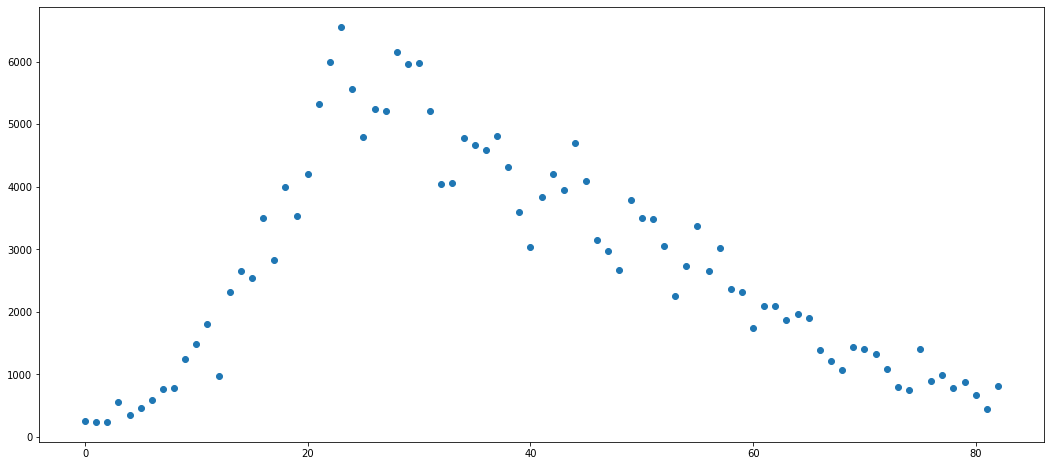

In [265]:
plt.scatter(italy_set.index,italy_set['New cases'])

MEDIA MOBILE PER ELIMINARE QUEI PUNTI ORRIBILI

In [266]:
Italy_set_am=pd.DataFrame()
window=7
Italy_set_am['New cases am']=moving_mean(italy_set['New cases'],window)
Italy_set_am=Italy_set_am.set_index(italy_dates[window-1:])

Italy_set_am

,New cases am
2020-03-05,348.428571
2020-03-06,424.285714
2020-03-07,501.142857
2020-03-08,599.142857
2020-03-09,762.714286
...,...
2020-05-16,802.428571
2020-05-17,812.857143
2020-05-18,803.000000
2020-05-19,667.142857


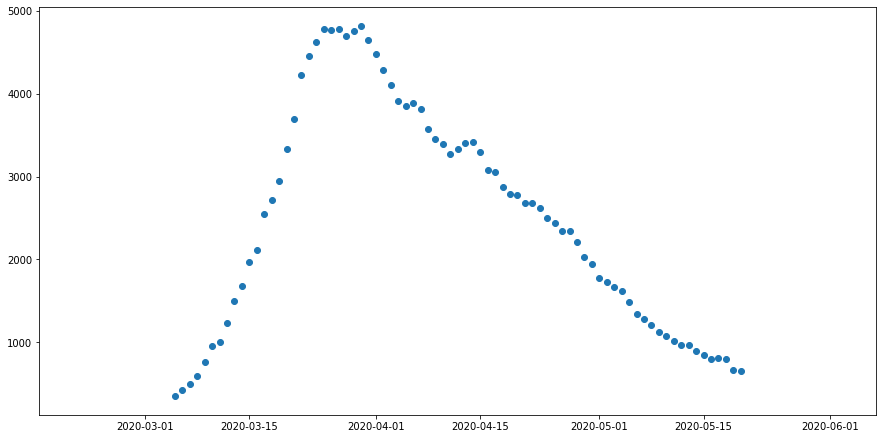

In [267]:
plt.figure(figsize=(15,7.5))

plt.scatter(italy_dates[window-1:],Italy_set_am['New cases am'])

PRENDIAMO LA CURVA DAL PICCO

Linear Regression Model Score: 0.987747927064742


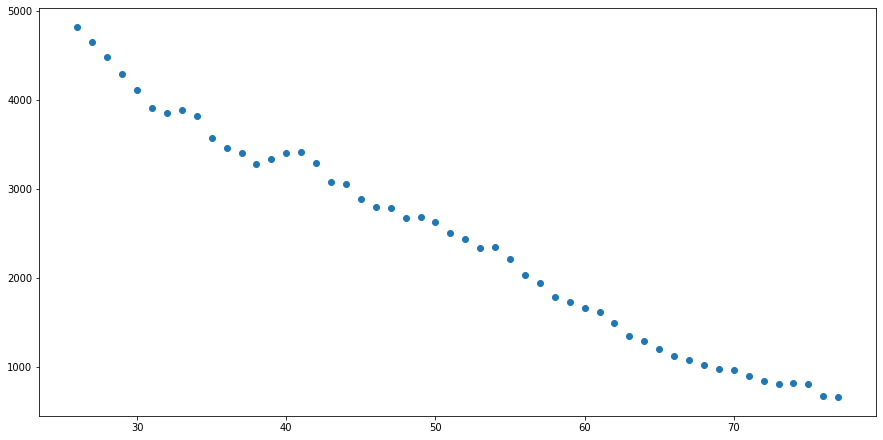

In [268]:

X, y, peak_date, linear_regr = curveAfterPeak(italy_dates,Italy_set_am['New cases am'])

PREDICIAMO QUANDO ARRIVERà A 0

0.6398700191339646


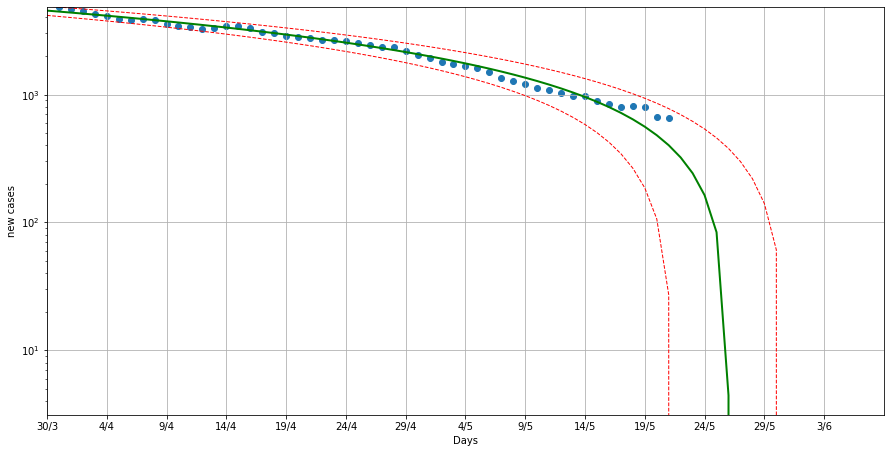

In [94]:
train_value=int(len(X)*0.70)-1

X_train=X[0:train_value]

y_train=y[0:train_value]

y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,Italy_set_am.index, linear_regr,y_test,70)

In [269]:
for i in range(0,len(df_matrix_new_cases['United States'])):
        if(df_matrix_new_cases['United States'][i]>200):
                 
                     us_cases=np.array(df_matrix_new_cases['United States'][i:])
                     us_dates=np.array(df_matrix_new_cases.index[i:])
                     break

us_cases
us_dates
us_set=pd.DataFrame()
us_set['New cases']=us_cases
us_set.set_index(us_dates)

,New cases
2020-03-11,271
2020-03-12,287
2020-03-13,351
2020-03-14,511
2020-03-15,777
...,...
2020-05-16,25508
2020-05-17,24487
2020-05-18,18873
2020-05-19,21841


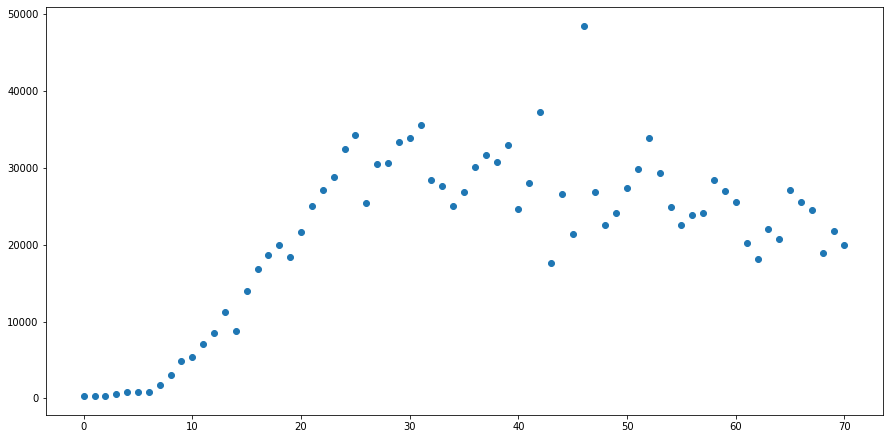

In [270]:
plt.figure(figsize=(15,7.5))
plt.scatter(us_set.index,us_set['New cases'])

In [271]:
us_set_am=pd.DataFrame()
window=7
us_set_am['New cases am']=moving_mean(us_set['New cases'],window)
us_set_am=us_set_am.set_index(us_dates[window-1:])

us_set_am.head()

,New cases am
2020-03-17,519.428571
2020-03-18,730.714286
2020-03-19,1107.428571
2020-03-20,1725.142857
2020-03-21,2381.857143


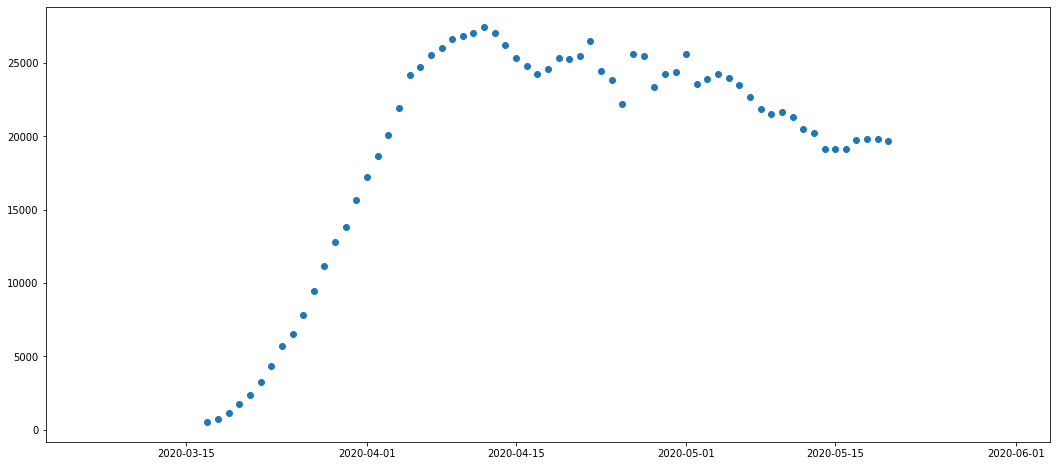

In [272]:
plt.scatter(us_dates[window-1:],us_set_am['New cases am'])

Linear Regression Model Score: 0.8154799818365772


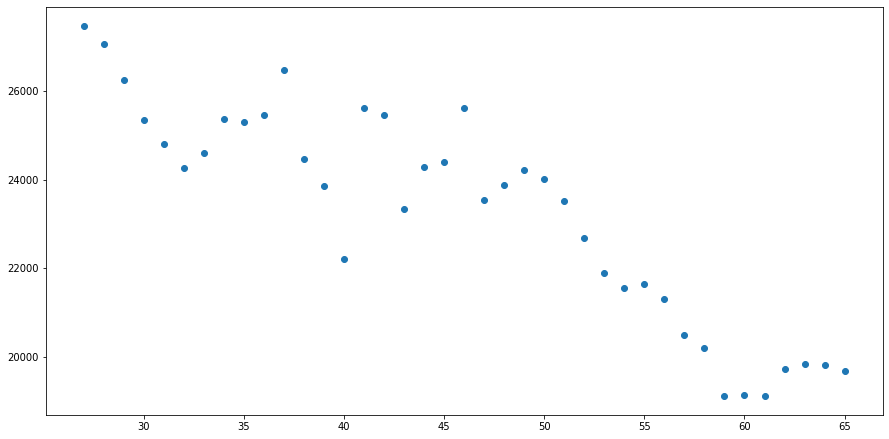

In [273]:
X, y, peak_date, linear_regr = curveAfterPeak(us_dates,us_set_am['New cases am'])

-0.08257859044498561


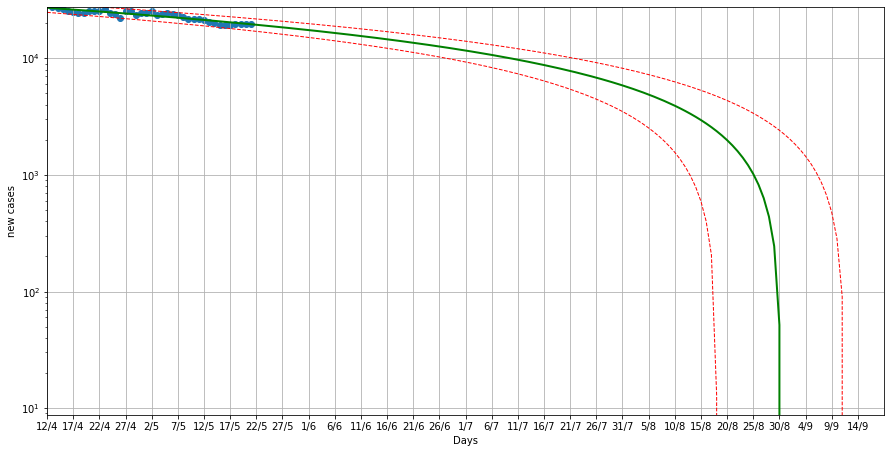

In [275]:
train_value=int(len(X)*0.70)

X_train=X[0:train_value]

y_train=y[0:train_value]

y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,us_set_am.index, linear_regr,y_test,160)

UK 

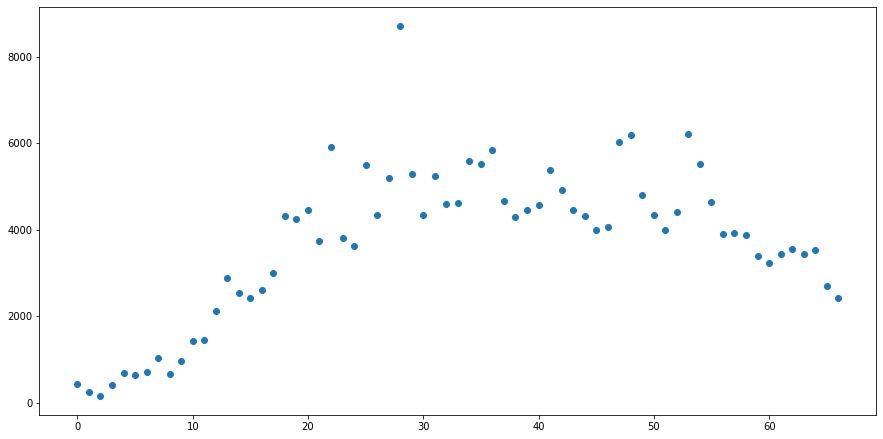

In [276]:
for i in range(0,len(df_matrix_new_cases['United Kingdom'])):
        if(df_matrix_new_cases['United Kingdom'][i]>200):
                 
                     uk_cases=np.array(df_matrix_new_cases['United Kingdom'][i:])
                     uk_dates=np.array(df_matrix_new_cases.index[i:])
                     break

uk_cases
uk_dates
uk_set=pd.DataFrame()
uk_set['New cases']=uk_cases
uk_set.set_index(uk_dates)
plt.figure(figsize=(15,7.5))

plt.scatter(uk_set.index,uk_set['New cases'])

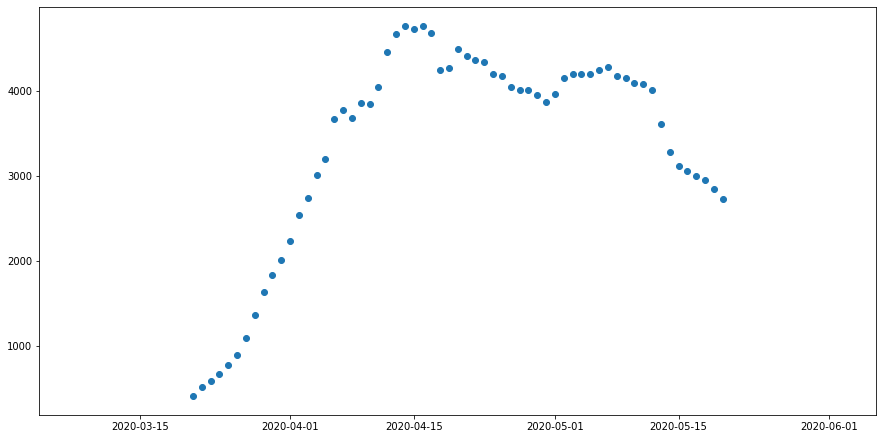

In [277]:
uk_set_am=pd.DataFrame()
window=7
uk_set_am['New cases am']=moving_mean(uk_set['New cases'],window)
uk_set_am=uk_set_am.set_index(uk_dates[window-1:])
plt.figure(figsize=(15,7.5))
uk_set_am.head()
plt.scatter(uk_dates[window-1:],uk_set_am['New cases am'])

Linear Regression Model Score: 0.6755763348213706


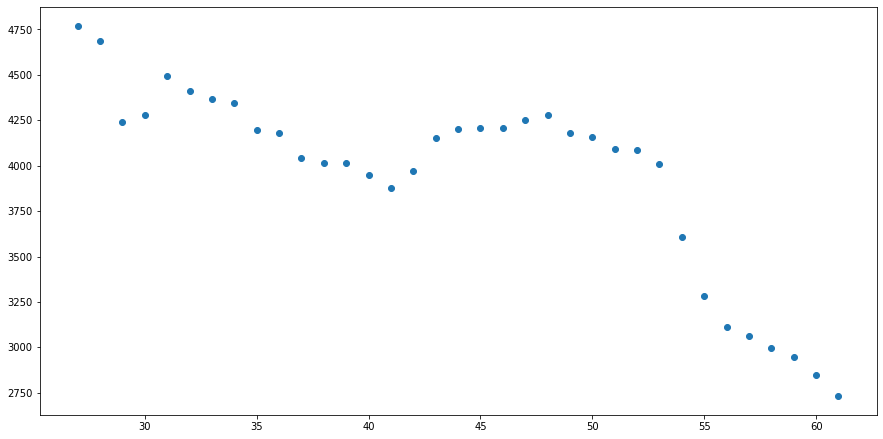

In [278]:
X, y, peak_date, linear_regr = curveAfterPeak(uk_dates,uk_set_am['New cases am'])

0.3728116221236154


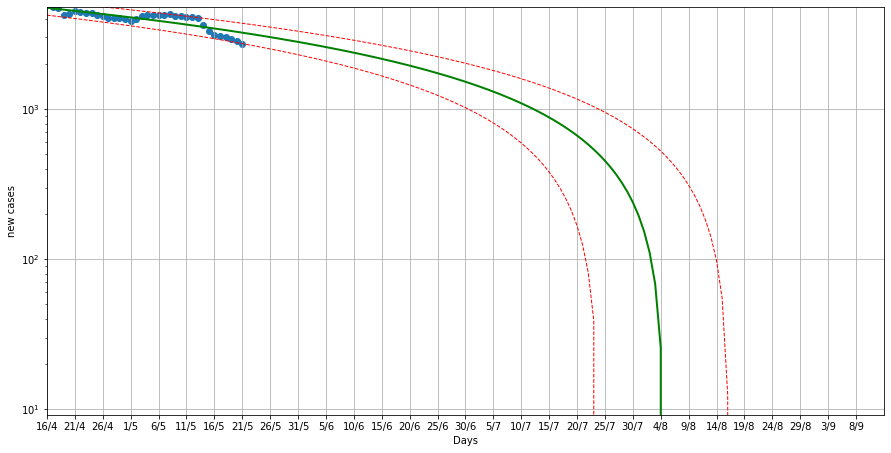

In [279]:
train_value=int(len(X)*0.70)

X_train=X[0:train_value]

y_train=y[0:train_value]

y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,uk_set_am.index, linear_regr,y_test,150)

NIHON

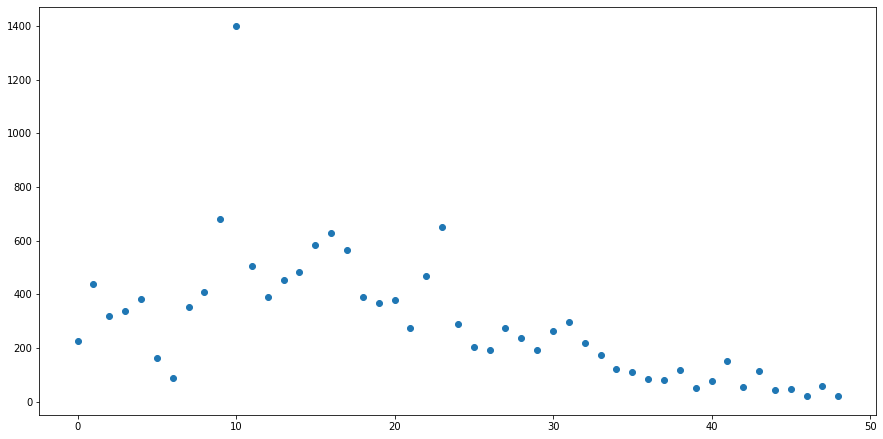

In [284]:
for i in range(0,len(df_matrix_new_cases['Japan'])):
        if(df_matrix_new_cases['Japan'][i]>200):
                 
                     jp_cases=np.array(df_matrix_new_cases['Japan'][i:])
                     jp_dates=np.array(df_matrix_new_cases.index[i:])
                     break

jp_cases
jp_dates
jp_set=pd.DataFrame()
jp_set['New cases']=jp_cases
jp_set.set_index(jp_dates)
plt.figure(figsize=(15,7.5))

plt.scatter(jp_set.index,jp_set['New cases'])

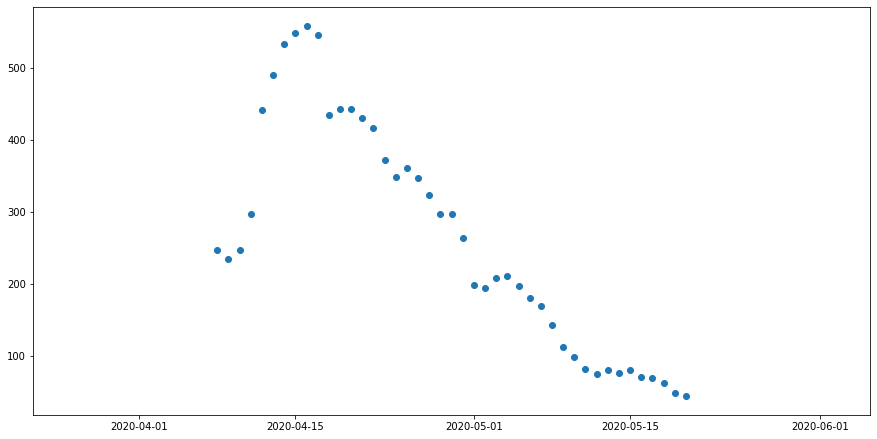

In [285]:
jp_set_am=pd.DataFrame()
window=7
jp_set_am['New cases am']=moving_mean(jp_set['New cases'],window)
jp_set_am=jp_set_am.set_index(jp_dates[window-1:])
plt.figure(figsize=(15,7.5))
jp_set_am.head()
plt.scatter(jp_dates[window-1:],jp_set_am['New cases am'])

Linear Regression Model Score: 0.9535100025598223


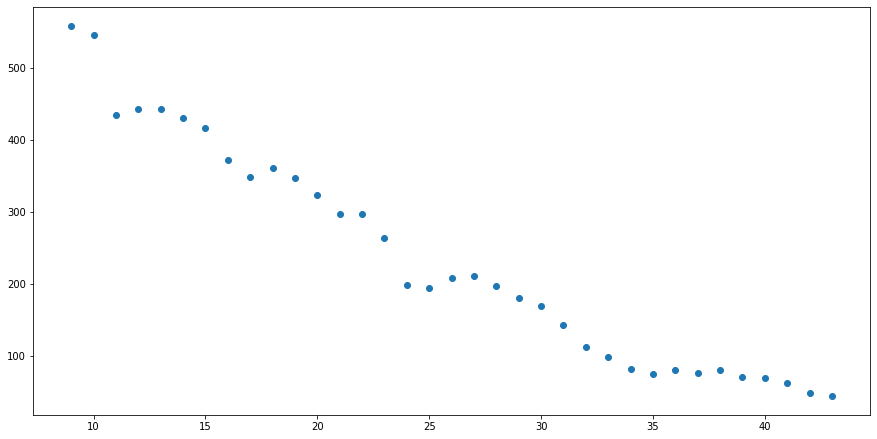

In [286]:
X, y, peak_date, linear_regr = curveAfterPeak(jp_dates,jp_set_am['New cases am'])

-4.225523076487144


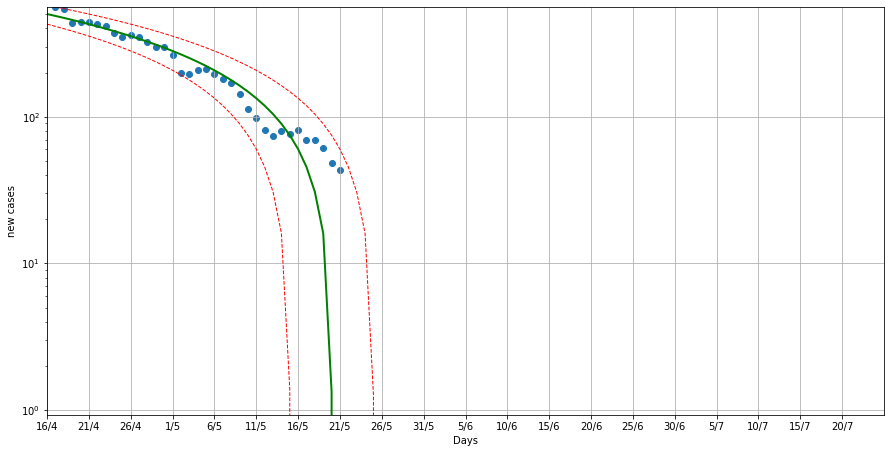

In [287]:
train_value=int(len(X)*0.70)

X_train=X[0:train_value]

y_train=y[0:train_value]

y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,jp_set_am.index, linear_regr,y_test,100)

SWEDEN

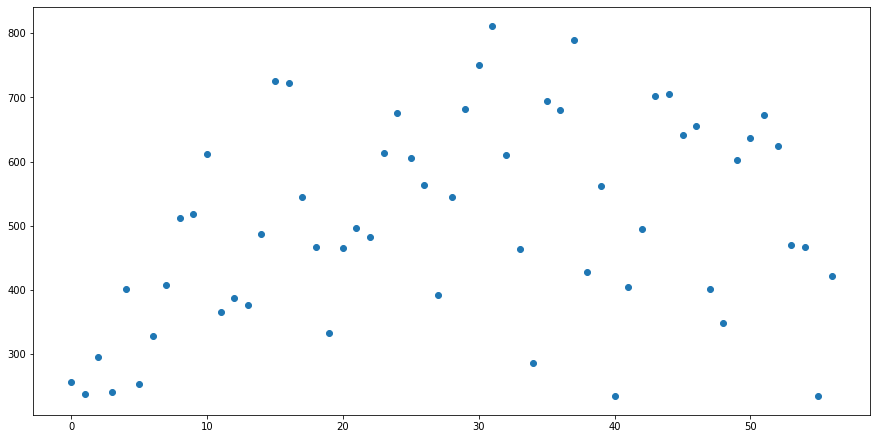

In [288]:
for i in range(0,len(df_matrix_new_cases['Sweden'])):
        if(df_matrix_new_cases['Sweden'][i]>200):
                 
                     sw_cases=np.array(df_matrix_new_cases['Sweden'][i:])
                     sw_dates=np.array(df_matrix_new_cases.index[i:])
                     break

sw_cases
sw_dates
sw_set=pd.DataFrame()
sw_set['New cases']=sw_cases
sw_set.set_index(sw_dates)
plt.figure(figsize=(15,7.5))

plt.scatter(sw_set.index,sw_set['New cases'])

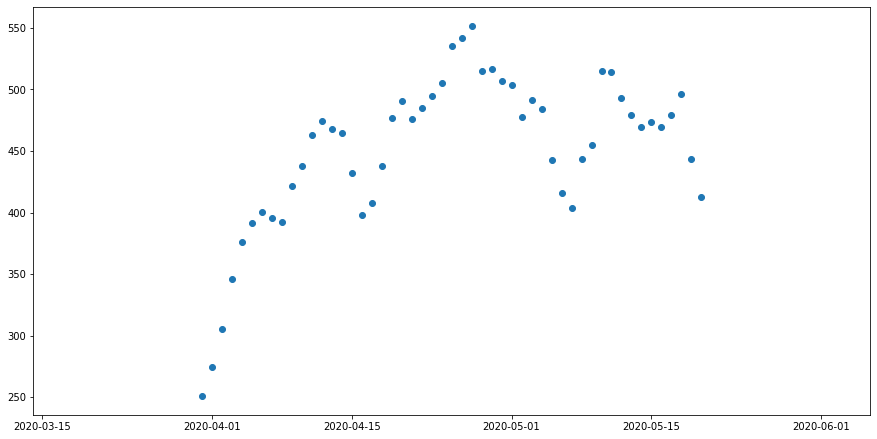

In [289]:
sw_set_am=pd.DataFrame()
window=7
sw_set_am['New cases am']=moving_mean(sw_set['New cases'],window)
sw_set_am=sw_set_am.set_index(sw_dates[window-1:])
plt.figure(figsize=(15,7.5))
sw_set_am.head()
plt.scatter(sw_dates[window-1:],sw_set_am['New cases am'])

Linear Regression Model Score: 0.18968212940379037


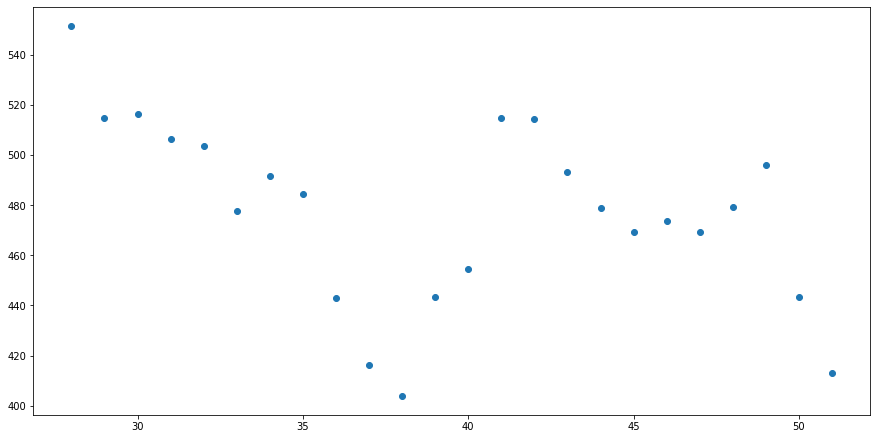

In [290]:
X, y, peak_date, linear_regr = curveAfterPeak(sw_dates,sw_set_am['New cases am'])

0.17646453973283682


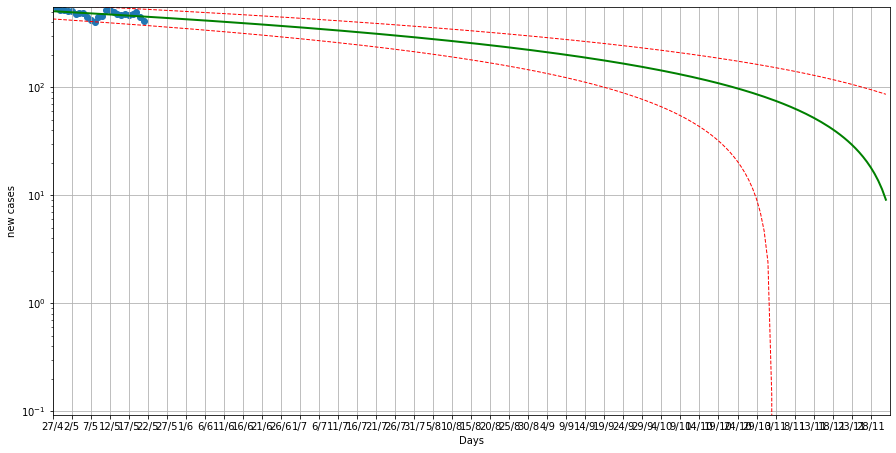

In [291]:
train_value=int(len(X)*0.70)

X_train=X[0:train_value]

y_train=y[0:train_value]

y_test=y[train_value:]

predictTrain(X, y, X_train,y_train,peak_date,sw_set_am.index, linear_regr,y_test,220)